<a href="https://colab.research.google.com/github/showmeinfinity/final_project/blob/main/Step_1_Preprocessing_data_and_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note that this notebook is run using Google Colab*

# Pre-process MD-Agreement datasets

In [ ]:
!pip install contractions
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 11.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import autoviz
from wordcloud import WordCloud
import re
import string
import nltk
import contractions
from nltk.corpus import stopwords
import emoji
import html
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

In [ ]:
import warnings
warnings.simplefilter("ignore")

In [ ]:
# Set random seed for reproducibility
np.random.seed(13)

In [ ]:
# Load the JSON data from the files
with open("MD-Agreement_test.json", "r") as file_test:
    data_test = json.load(file_test)

with open("MD-Agreement_dev.json", "r") as file_dev:
    data_dev = json.load(file_dev)

with open("MD-Agreement_train.json", "r") as file_train:
    data_train = json.load(file_train)

# Check the type and length of the loaded data to understand its structure
data_types = {
    "test": {
        "type": type(data_test),
        "length": len(data_test) if isinstance(data_test, (list, dict)) else None
    },
    "dev": {
        "type": type(data_dev),
        "length": len(data_dev) if isinstance(data_dev, (list, dict)) else None
    },
    "train": {
        "type": type(data_train),
        "length": len(data_train) if isinstance(data_train, (list, dict)) else None
    }
}

data_types

{'test': {'type': dict, 'length': 3057},
 'dev': {'type': dict, 'length': 1104},
 'train': {'type': dict, 'length': 6592}}

In [ ]:
# Combine the data from the three files into a single dictionary
combined_data = {
    "test": data_test,
    "dev": data_dev,
    "train": data_train
}

# Save the combined data to a new JSON file
output_file_path = "combined_data.json"
with open(output_file_path, "w") as output_file:
    json.dump(combined_data, output_file, indent=4)

output_file_path

'combined_data.json'

In [ ]:
# Initialise an empty list to store the dataframes from each split
dfs = []

# Loop through each split in the combined JSON data
for split_name, split_data in combined_data.items():
    # Extract the necessary fields and store them in a list
    rows = []
    for _, entry in split_data.items():
        row = {
            'text': entry['text'],
            'annotation task': entry['annotation task'],
            'number of annotations': entry['number of annotations'],
            'annotations': entry['annotations'],
            'annotators': entry['annotators'],
            'lang': entry['lang'],
            'hard_label': int(entry['hard_label']),
            'split': entry['split'],
            'soft_label.0': entry['soft_label']['0'],
            'soft_label.1': entry['soft_label']['1'],
            'other_info.domain': entry['other_info']['domain']
        }
        rows.append(row)

    # Convert the list of rows into a dataframe
    df = pd.DataFrame(rows)
    dfs.append(df)

# Concatenate the dataframes from each split
combined_df = pd.concat(dfs, ignore_index=True)

# Save the combined dataframe to a CSV file
output_csv_path = "combined_data.csv"
combined_df.to_csv(output_csv_path, index=False)

output_csv_path


'combined_data.csv'


**Restructure the dataframe**

In [ ]:
combined_df

,text,annotation task,number of annotations,annotations,annotators,lang,hard_label,split,soft_label.0,soft_label.1,other_info.domain
0,"<user> <user> 30 million unemployed , fool",offensiveness detection,5,"1,0,0,0,0","Ann150,Ann626,Ann85,Ann789,Ann283",en,0,test,0.8,0.2,Elections2020
1,. <user> <user> <user> <user> <user> <user> #W...,offensiveness detection,5,"0,0,0,0,0","Ann633,Ann158,Ann639,Ann448,Ann283",en,0,test,1.0,0.0,BLM
2,"If you watched the entire #GeorgeFloyd porno, ...",offensiveness detection,5,"1,1,1,1,1","Ann535,Ann206,Ann229,Ann236,Ann408",en,1,test,0.0,1.0,BLM
3,<user> Stay away from children.,offensiveness detection,5,"0,0,1,1,0","Ann770,Ann538,Ann272,Ann170,Ann150",en,0,test,0.6,0.4,Elections2020
4,<user> <user> No super-spreader accusations as...,offensiveness detection,5,"1,0,1,1,1","Ann107,Ann313,Ann484,Ann283,Ann448",en,1,test,0.2,0.8,Covid-19
...,...,...,...,...,...,...,...,...,...,...,...
10748,Instead of showing compassion and empathy..thi...,offensiveness detection,5,"0,0,0,0,0","Ann740,Ann577,Ann65,Ann775,Ann681",en,0,train,1.0,0.0,BLM
10749,<user> Neither did you,offensiveness detection,5,"0,0,0,0,0","Ann88,Ann85,Ann779,Ann793,Ann656",en,0,train,1.0,0.0,Elections2020
10750,"""University of Toronto, McMaster University, S...",offensiveness detection,5,"0,0,0,0,0","Ann632,Ann517,Ann514,Ann64,Ann609",en,0,train,1.0,0.0,Covid-19
10751,The only people ripping this country apart are...,offensiveness detection,5,"0,1,1,0,0","Ann493,Ann586,Ann239,Ann347,Ann661",en,0,train,0.6,0.4,BLM


In [ ]:
# Checking for missing values
missing_values = combined_df.isnull().sum()
missing_values

text                     0
annotation task          0
number of annotations    0
annotations              0
annotators               0
lang                     0
hard_label               0
split                    0
soft_label.0             0
soft_label.1             0
other_info.domain        0
dtype: int64

In [ ]:
# Create 'instance_id' column
combined_df['instance_id'] = range(1, len(combined_df) + 1)

# Split 'annotators' and 'annotations' columns
combined_df['annotators'] = combined_df['annotators'].str.split(',')
combined_df['annotations'] = combined_df['annotations'].str.split(',')

# Check the first few rows after transformations
combined_df.head()


,text,annotation task,number of annotations,annotations,annotators,lang,hard_label,split,soft_label.0,soft_label.1,other_info.domain,instance_id
0,"<user> <user> 30 million unemployed , fool",offensiveness detection,5,"[1, 0, 0, 0, 0]","[Ann150, Ann626, Ann85, Ann789, Ann283]",en,0,test,0.8,0.2,Elections2020,1
1,. <user> <user> <user> <user> <user> <user> #W...,offensiveness detection,5,"[0, 0, 0, 0, 0]","[Ann633, Ann158, Ann639, Ann448, Ann283]",en,0,test,1.0,0.0,BLM,2
2,"If you watched the entire #GeorgeFloyd porno, ...",offensiveness detection,5,"[1, 1, 1, 1, 1]","[Ann535, Ann206, Ann229, Ann236, Ann408]",en,1,test,0.0,1.0,BLM,3
3,<user> Stay away from children.,offensiveness detection,5,"[0, 0, 1, 1, 0]","[Ann770, Ann538, Ann272, Ann170, Ann150]",en,0,test,0.6,0.4,Elections2020,4
4,<user> <user> No super-spreader accusations as...,offensiveness detection,5,"[1, 0, 1, 1, 1]","[Ann107, Ann313, Ann484, Ann283, Ann448]",en,1,test,0.2,0.8,Covid-19,5


In [ ]:
# Check for any discrepancies in the lengths of the 'annotators' and 'annotations' columns
mismatched_rows = combined_df[combined_df['annotators'].str.len() != combined_df['annotations'].str.len()]

mismatched_rows


,text,annotation task,number of annotations,annotations,annotators,lang,hard_label,split,soft_label.0,soft_label.1,other_info.domain,instance_id
1682,"So ""vicious...despicable"" were not the officer...",offensiveness detection,5,"[0, 0, 0, 0, 1]","[Ann535, Ann158, Ann448, Ann383, Ann480, Ann579]",en,0,test,0.8,0.2,BLM,1683
2037,This World is nuts! Racism has been accepted f...,offensiveness detection,5,"[0, 0, 0, 0, 1]","[Ann535, Ann158, Ann448, Ann383, Ann480, Ann579]",en,0,test,0.8,0.2,BLM,2038


Note: These two rows are removed as the number of annotators and number of annotations do not match

In [ ]:
# Remove the mismatched rows
combined_df = combined_df.drop(index=mismatched_rows.index)

# Attempt the explode operation and make sure there are no mismatched rows issue
try:
    md_agreement_exploded = combined_df.set_index(['instance_id', 'text', 'annotation task', 'number of annotations', 'lang', 'hard_label', 'split', 'soft_label.0', 'soft_label.1', 'other_info.domain']).apply(pd.Series.explode).reset_index()
    success = True
except ValueError as e:
    success = False
    error_message = str(e)

success, error_message if not success else "Exploded successfully."


(True, 'Exploded successfully.')

In [ ]:
# Convert the annotation scores to integer
md_agreement_exploded['annotations'] = md_agreement_exploded['annotations'].astype(int)

# Rename the columns
md_agreement_exploded = md_agreement_exploded.rename(columns={"annotators": "user_id", "annotations": "offensiveness"})

# Modify the 'user_id' column to extract the numerical part
md_agreement_exploded['user_id'] = md_agreement_exploded['user_id'].str.extract('(\d+)')

# Display the first few rows of the modified data
md_agreement_exploded

,instance_id,text,annotation task,number of annotations,lang,hard_label,split,soft_label.0,soft_label.1,other_info.domain,offensiveness,user_id
0,1,"<user> <user> 30 million unemployed , fool",offensiveness detection,5,en,0,test,0.8,0.2,Elections2020,1,150
1,1,"<user> <user> 30 million unemployed , fool",offensiveness detection,5,en,0,test,0.8,0.2,Elections2020,0,626
2,1,"<user> <user> 30 million unemployed , fool",offensiveness detection,5,en,0,test,0.8,0.2,Elections2020,0,85
3,1,"<user> <user> 30 million unemployed , fool",offensiveness detection,5,en,0,test,0.8,0.2,Elections2020,0,789
4,1,"<user> <user> 30 million unemployed , fool",offensiveness detection,5,en,0,test,0.8,0.2,Elections2020,0,283
...,...,...,...,...,...,...,...,...,...,...,...,...
53750,10753,"Facts!!! #Repost miss_pr_piggy ・・・ ""Gen Z wil...",offensiveness detection,5,en,0,train,1.0,0.0,BLM,0,117
53751,10753,"Facts!!! #Repost miss_pr_piggy ・・・ ""Gen Z wil...",offensiveness detection,5,en,0,train,1.0,0.0,BLM,0,513
53752,10753,"Facts!!! #Repost miss_pr_piggy ・・・ ""Gen Z wil...",offensiveness detection,5,en,0,train,1.0,0.0,BLM,0,755
53753,10753,"Facts!!! #Repost miss_pr_piggy ・・・ ""Gen Z wil...",offensiveness detection,5,en,0,train,1.0,0.0,BLM,0,455


In [ ]:
md_agreement_exploded.to_csv("md_agreement_transformed.csv", index=False)

## Do some EDA

In [ ]:
# Create a heatmap visualisation
def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

# Plot domain and split of MD-Agreement
chart = heatmap(md_agreement_exploded, *['split', 'other_info.domain'], **{})
chart

Text(0.5, 1.0, 'Distribution of Text Lengths')

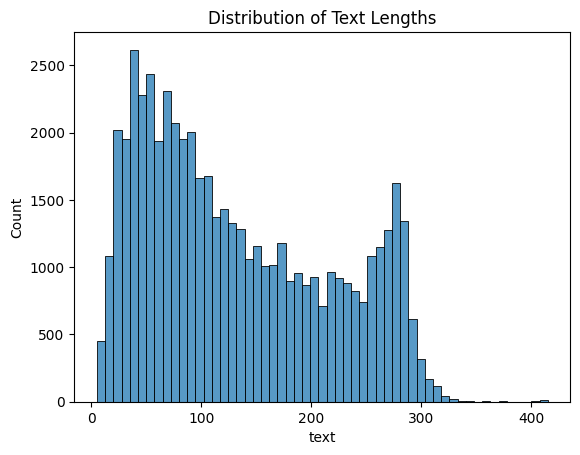

In [ ]:
# Plot the distribution of text lengths
text_lengths = md_agreement_exploded['text'].apply(len)
sns.histplot(text_lengths)
plt.title("Distribution of Text Lengths")

In [ ]:
# Display the distribution of offensiveness column
def plot_offensiveness_distribution(df):
    plt.figure(figsize=(8, 6))
    plt.hist(df['offensiveness'], edgecolor='k')
    plt.xlabel('Offensiveness Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Offensiveness Score')
    plt.grid(True)
    plt.show()

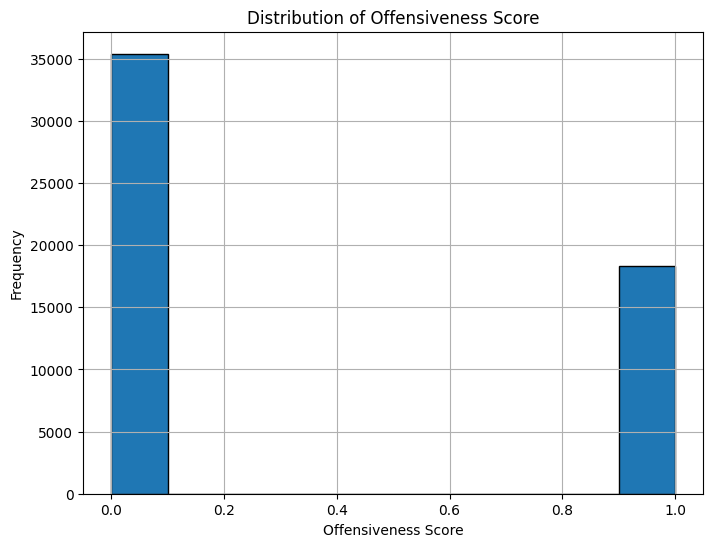

In [ ]:
# Plot distribution for md_agreement
plot_offensiveness_distribution(md_agreement_exploded)

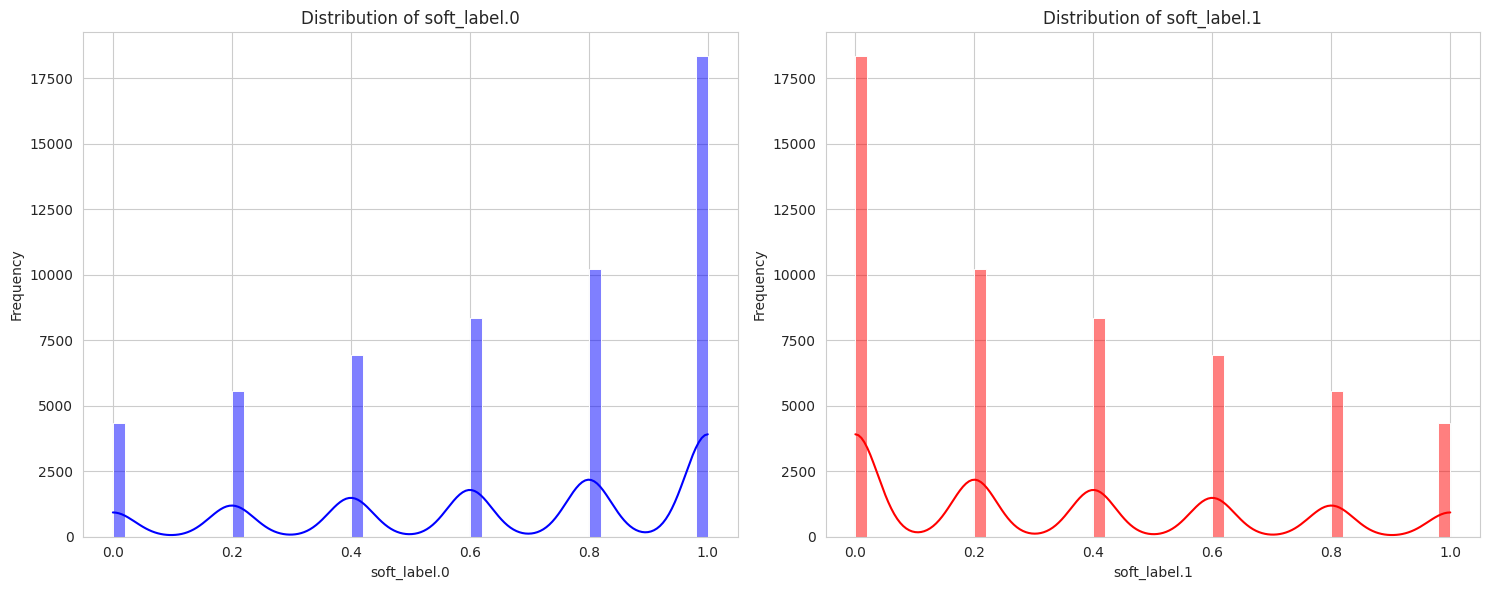

In [ ]:
# Set up the plotting style
sns.set_style("whitegrid")

# Create a figure with 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot the distribution of soft_label.0
sns.histplot(md_agreement_exploded['soft_label.0'], ax=axes[0], kde=True, bins=50, color='blue')
axes[0].set_title('Distribution of soft_label.0')
axes[0].set_xlabel('soft_label.0')
axes[0].set_ylabel('Frequency')

# Plot the distribution of soft_label.1
sns.histplot(md_agreement_exploded['soft_label.1'], ax=axes[1], kde=True, bins=50, color='red')
axes[1].set_title('Distribution of soft_label.1')
axes[1].set_xlabel('soft_label.1')
axes[1].set_ylabel('Frequency')

# Display the plots
plt.tight_layout()
plt.show()

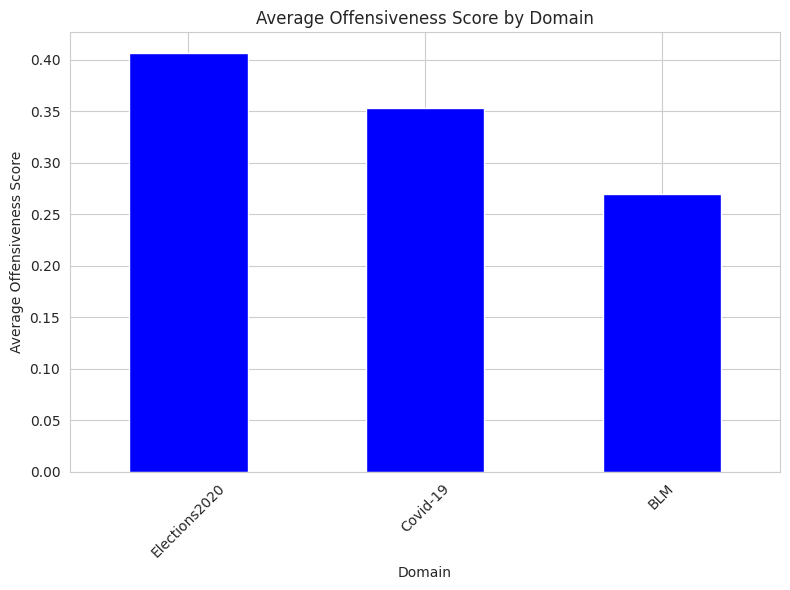

In [ ]:
# Group by domain and calculate the mean offensiveness score
avg_offensiveness_by_domain = md_agreement_exploded.groupby('other_info.domain')['offensiveness'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 6))
avg_offensiveness_by_domain.plot(kind='bar', color='blue')
plt.title("Average Offensiveness Score by Domain")
plt.ylabel("Average Offensiveness Score")
plt.xlabel("Domain")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

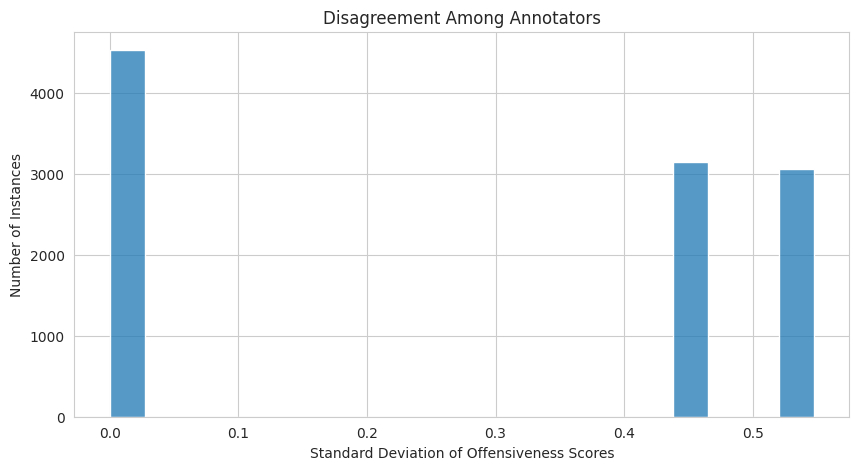

In [ ]:
# Compute the standard deviation of the offensiveness scores for each instance
disagreement = md_agreement_exploded.groupby('instance_id')['offensiveness'].std()

# Create a histogram of the disagreement scores
plt.figure(figsize=(10, 5))
sns.histplot(disagreement, bins=20)
plt.title("Disagreement Among Annotators")
plt.xlabel("Standard Deviation of Offensiveness Scores")
plt.ylabel("Number of Instances")
plt.show()


# Pre-process offensiveness POPQUORN daatset

In [ ]:
offensiveness_popquorn = pd.read_csv('offensiveness_popquorn.csv')

In [ ]:
offensiveness_popquorn

,instance_id,user_id,text,offensiveness,gender,race,age,occupation,education
0,530,0,"I think a lot of Dethklok songs use drop C, wo...",1.0,Man,White,35-39,Unemployed,High school diploma or equivalent
1,1280,0,There are relatively simple ways around all of...,1.0,Man,White,35-39,Unemployed,High school diploma or equivalent
2,621,0,Tell the british soldier in WW1 to shoot that ...,1.0,Man,White,35-39,Unemployed,High school diploma or equivalent
3,676,0,Top comment pretty much. I have gay friends an...,1.0,Man,White,35-39,Unemployed,High school diploma or equivalent
4,635,0,Don't tell them just let them and their liniag...,3.0,Man,White,35-39,Unemployed,High school diploma or equivalent
...,...,...,...,...,...,...,...,...,...
13031,471,262,They’re closed anti-vaxx Facebook groups. When...,1.0,Woman,Asian,54-59,Self-employed,College degree
13032,1033,262,Bioethics; an interesting field in which the w...,1.0,Woman,Asian,54-59,Self-employed,College degree
13033,740,262,Or they are really secure but hang around inse...,5.0,Woman,Asian,54-59,Self-employed,College degree
13034,894,262,Don't have to worry about being too big to fit...,4.0,Woman,Asian,54-59,Self-employed,College degree


In [ ]:
# Checking for missing values
missing_values = offensiveness_popquorn.isnull().sum()
missing_values

instance_id      0
user_id          0
text             0
offensiveness    0
gender           0
race             0
age              0
occupation       0
education        0
dtype: int64

## Do some EDA

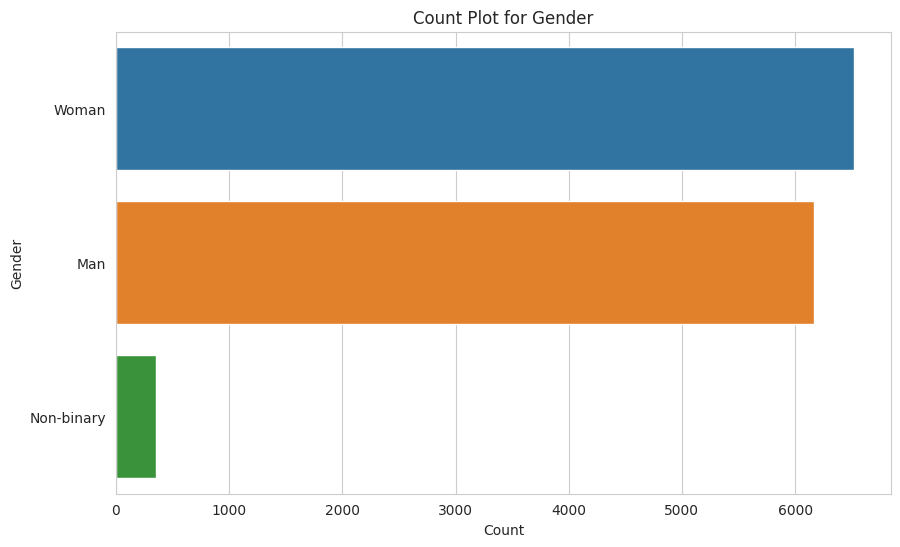

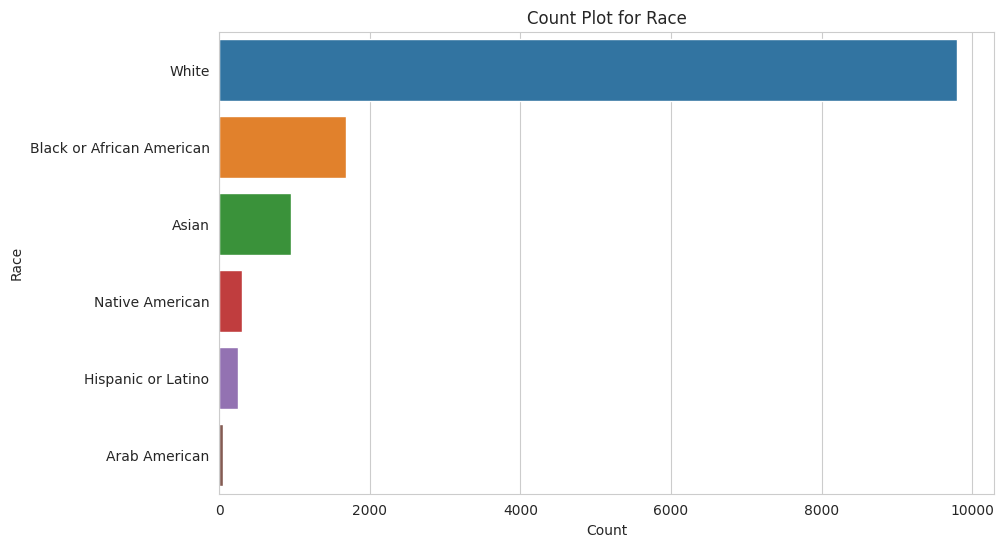

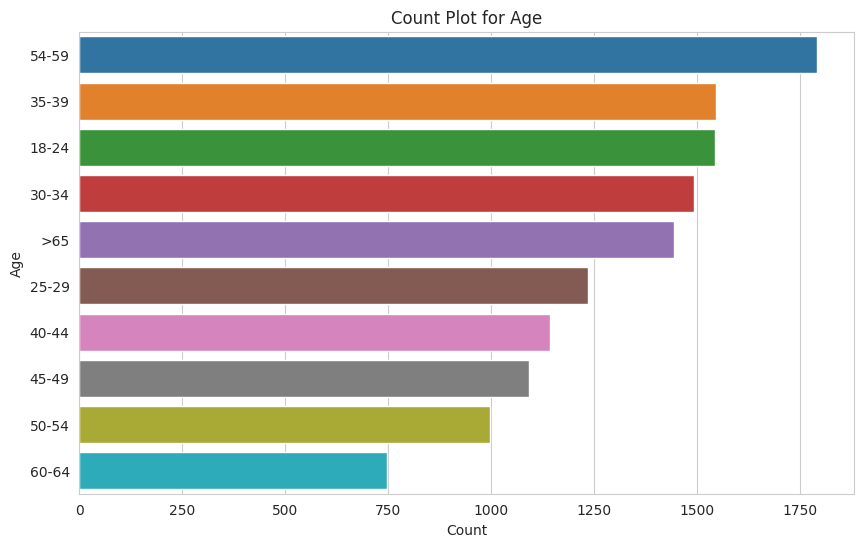

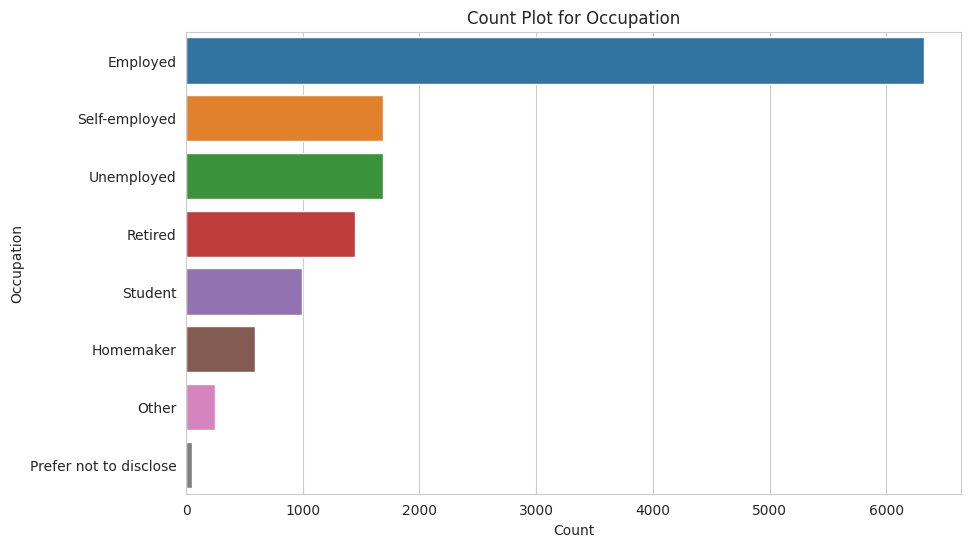

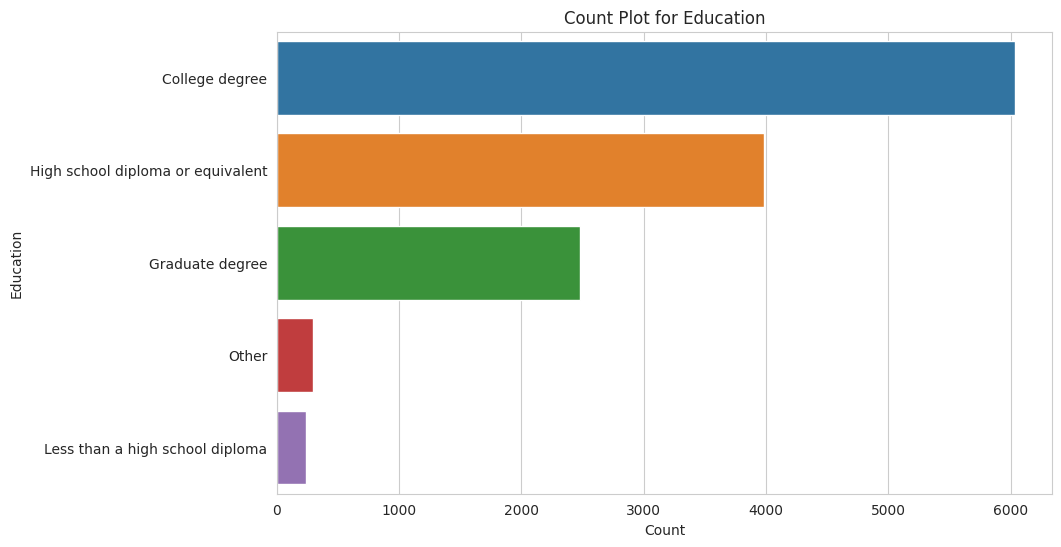

In [ ]:
### Show split of offensiveness, gender, race, age, occupation, education

# Function to plot count plot for a given column
def plot_count(column):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=offensiveness_popquorn, y=column, order=offensiveness_popquorn[column].value_counts().index)
    plt.title(f'Count Plot for {column.capitalize()}')
    plt.xlabel('Count')
    plt.ylabel(column.capitalize())
    plt.show()

# Columns to plot
columns_to_plot = ['gender', 'race', 'age', 'occupation', 'education']

# Plot count plots for the columns
for column in columns_to_plot:
    plot_count(column)

In [ ]:
# Calculate the average offensiveness score for each user
average_offensiveness = offensiveness_popquorn.groupby('user_id')['offensiveness'].mean().reset_index()
average_offensiveness

,user_id,offensiveness
0,0,1.46000
1,1,1.55102
2,2,2.02000
3,3,1.48000
4,4,2.02000
...,...,...
257,257,2.32000
258,258,3.28000
259,259,1.06000
260,261,1.20000


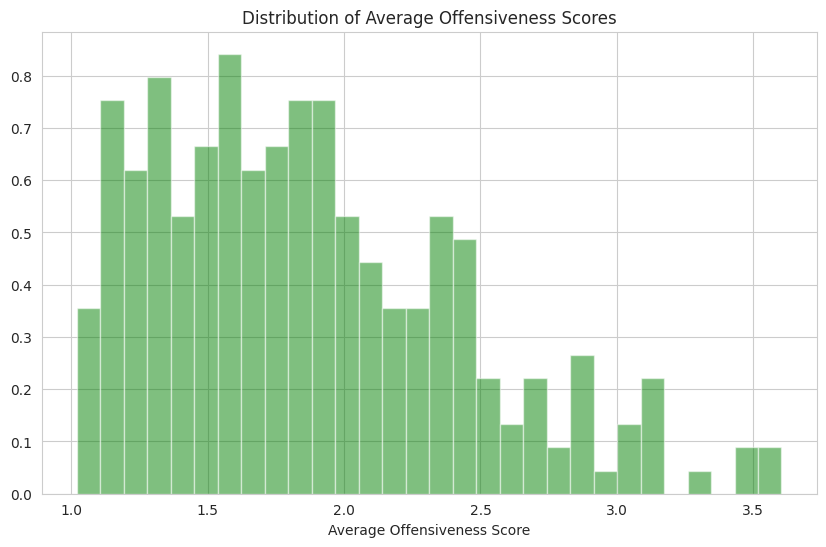

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(average_offensiveness['offensiveness'], bins=30, alpha=0.5, color='g', density=True)
plt.xlabel('Average Offensiveness Score')
plt.title('Distribution of Average Offensiveness Scores')
plt.grid(True)
plt.show()


Text(0.5, 1.0, 'Distribution of Text Lengths')

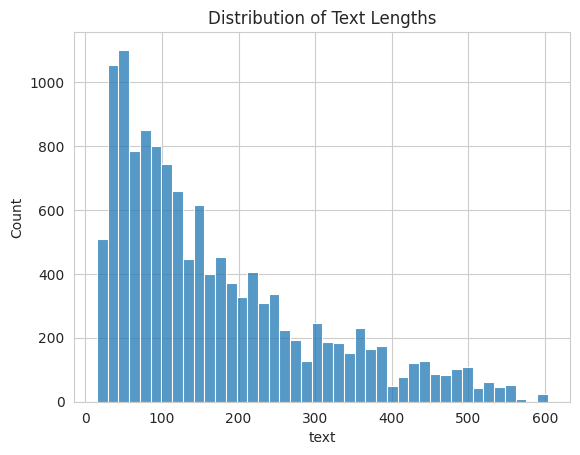

In [ ]:
# Plot the distribution of text lengths
text_lengths = offensiveness_popquorn['text'].apply(len)
sns.histplot(text_lengths)
plt.title("Distribution of Text Lengths")

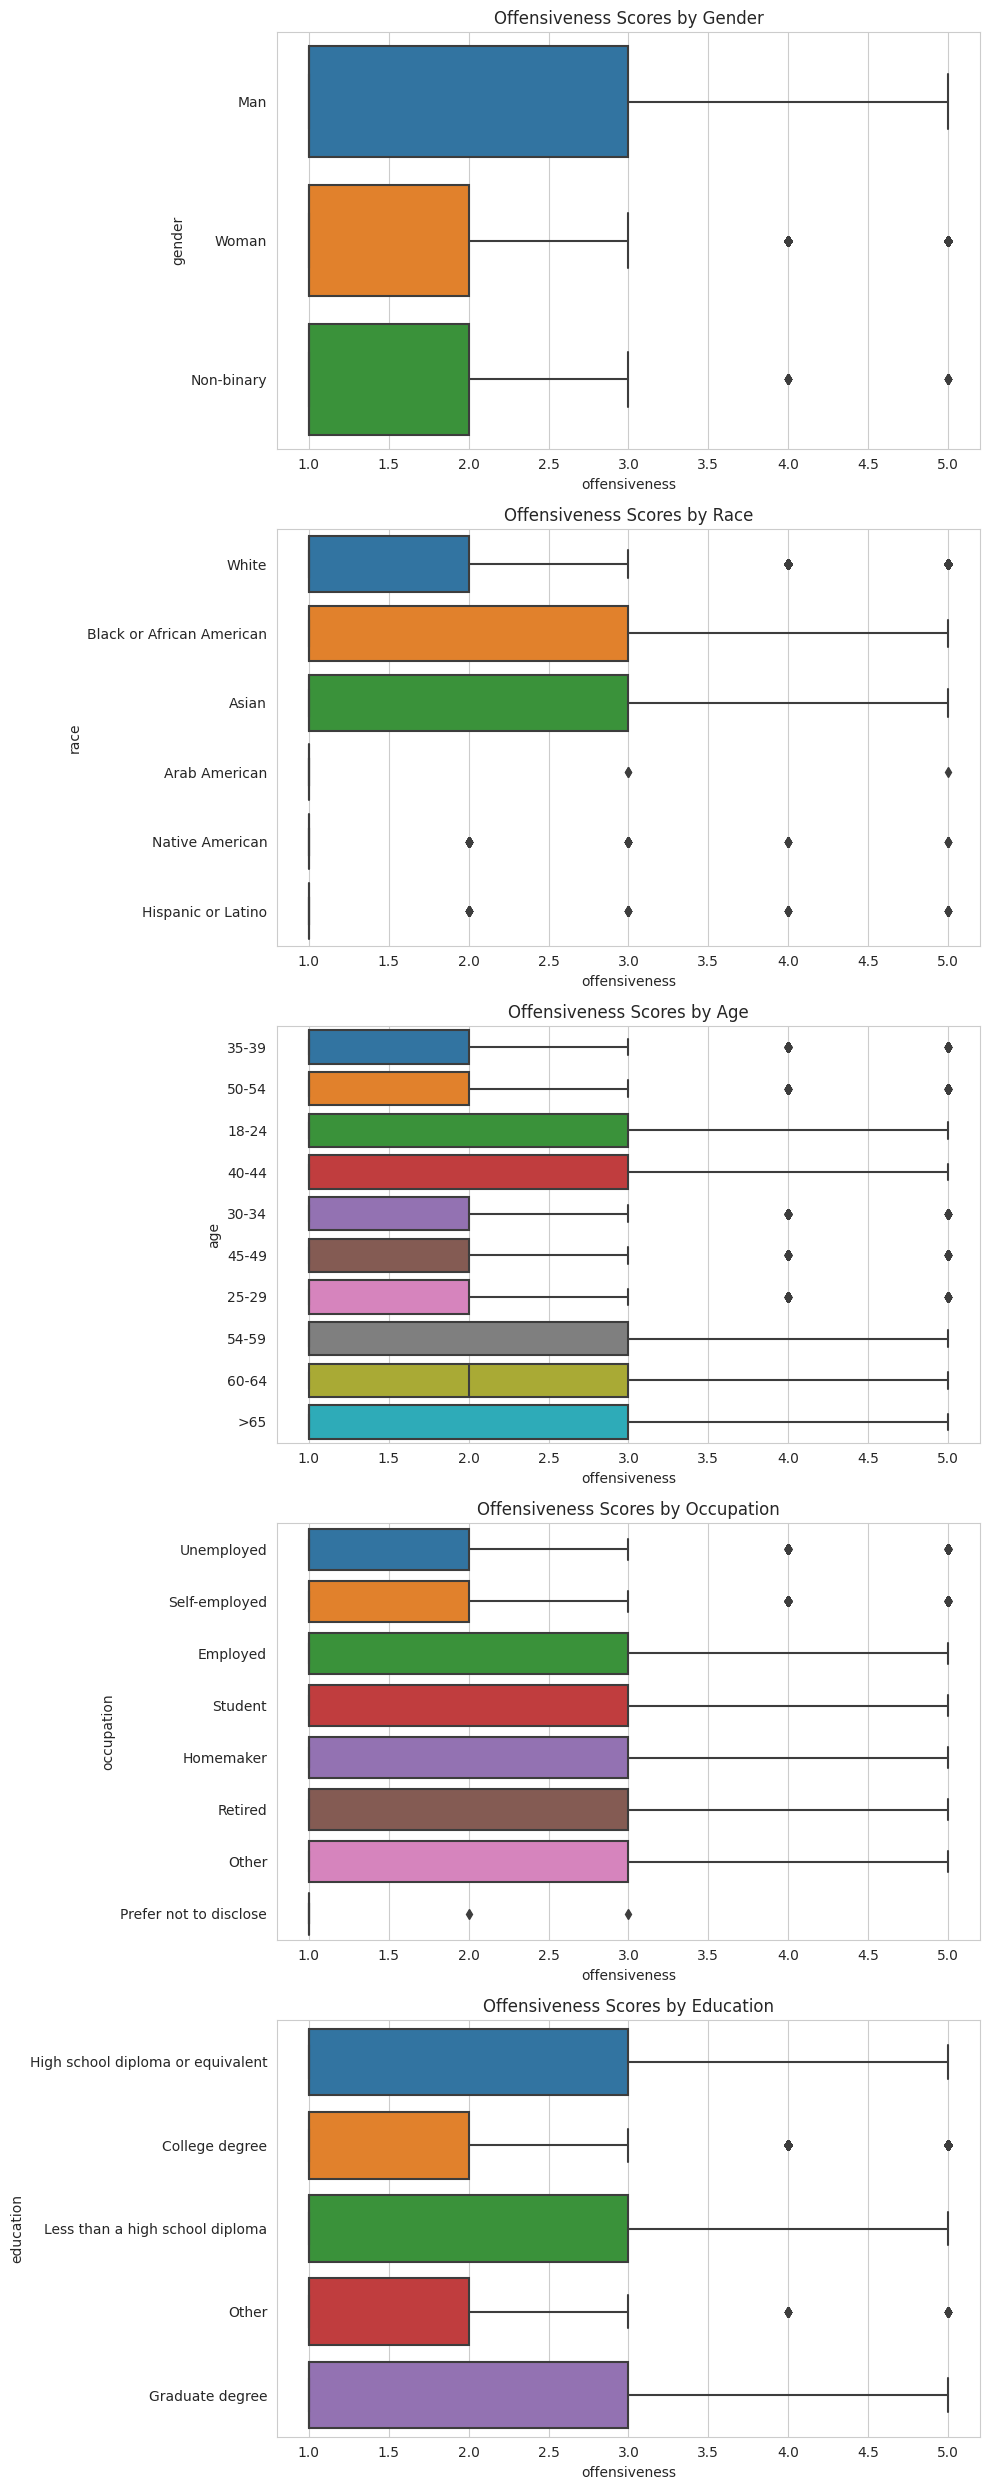

In [ ]:
# Analysing the relationship between the offensiveness score and the demographic attributes

# Create subplots
fig, axs = plt.subplots(5, 1, figsize=(10, 25))

# List of demographic attributes
demographics = ['gender', 'race', 'age', 'occupation', 'education']

# Generate boxplots for each demographic attribute
for i, demographic in enumerate(demographics):
    sns.boxplot(y=demographic, x="offensiveness", data=offensiveness_popquorn, ax=axs[i], orient='h')
    axs[i].set_title(f"Offensiveness Scores by {demographic.capitalize()}")

plt.tight_layout()
plt.show()


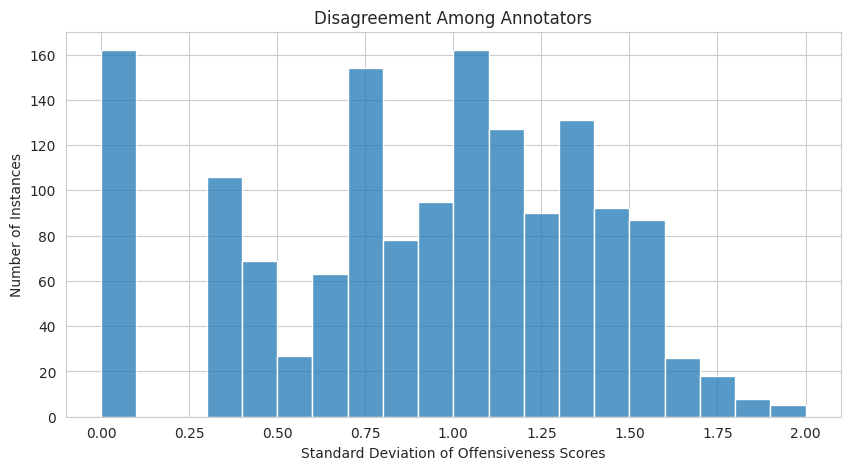

In [ ]:
# Compute the standard deviation of the offensiveness scores for each instance
disagreement = offensiveness_popquorn.groupby('instance_id')['offensiveness'].std()

# Create a histogram of the disagreement scores
plt.figure(figsize=(10, 5))
sns.histplot(disagreement, bins=20)
plt.title("Disagreement Among Annotators")
plt.xlabel("Standard Deviation of Offensiveness Scores")
plt.ylabel("Number of Instances")
plt.show()


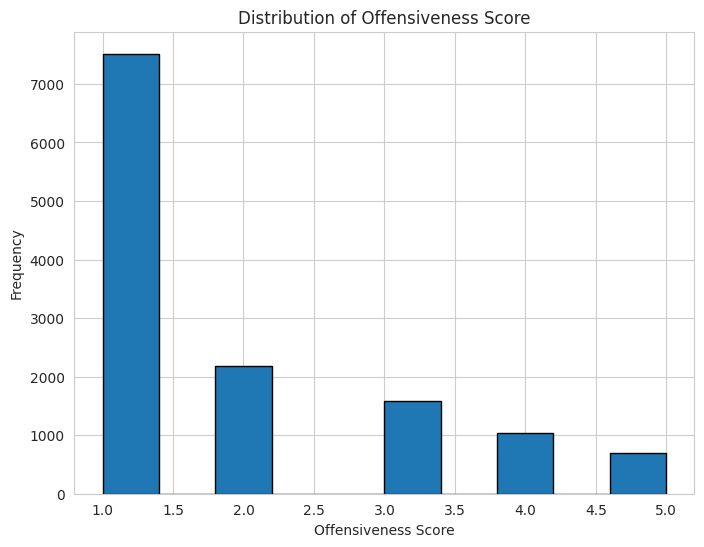

In [ ]:
# Plot distribution for 'offensiveness_popquorn' dataframe
plot_offensiveness_distribution(offensiveness_popquorn)

## Combine offensiveness scores to have a binary split for and to have more equal classes

In [ ]:
# Convert offensiveness scores to binary format
offensiveness_popquorn['offensiveness'] = offensiveness_popquorn['offensiveness'].replace({1: 0, 2: 1, 3: 1, 4: 1, 5: 1})

In [ ]:
def plot_grouped_offensiveness_distribution(df, df_name):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='offensiveness')
    plt.title(f"Distribution of 'offensiveness' in {df_name}")
    plt.show()

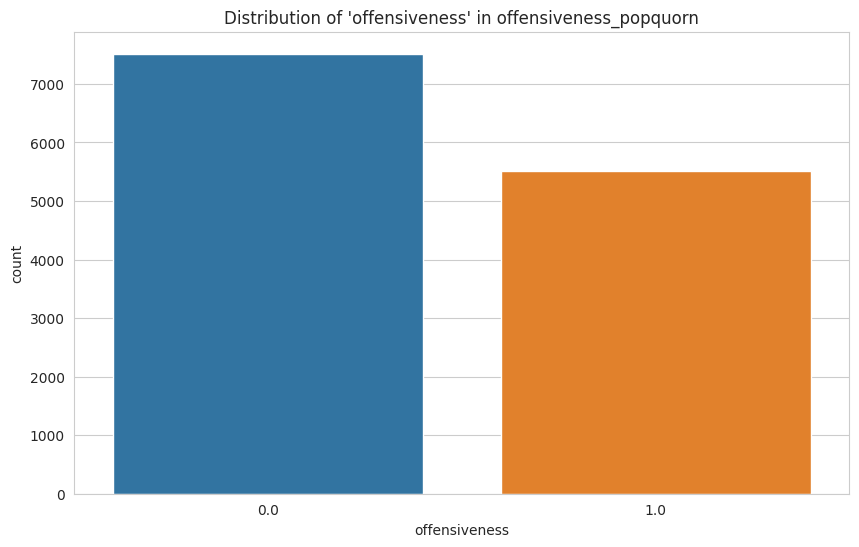

In [ ]:
plot_grouped_offensiveness_distribution(offensiveness_popquorn, 'offensiveness_popquorn')

## Create hard and soft labels for offensiveness_popquorn

In [ ]:
# Compute the count of 0s and 1s for each instance
count_0s = offensiveness_popquorn.groupby('instance_id')['offensiveness'].apply(lambda x: (x == 0).sum()).reset_index(name='count_0s')
count_1s = offensiveness_popquorn.groupby('instance_id')['offensiveness'].apply(lambda x: (x == 1).sum()).reset_index(name='count_1s')

# Merge the two counts
counts_df = pd.merge(count_0s, count_1s, on='instance_id')

# Identify instances with ties
ties_df = counts_df[counts_df['count_0s'] == counts_df['count_1s']]

ties_df

,instance_id,count_0s,count_1s
0,0,4,4
4,4,5,5
6,6,4,4
27,27,4,4
108,108,4,4
...,...,...,...
1432,1432,4,4
1491,1491,4,4
1495,1495,4,4
1498,1498,5,5


In [ ]:
len(ties_df)

85

In [ ]:
# Compute hard label for each instance
def compute_hard_label(x):
    if x.name in ties_df['instance_id'].values:
        return 1
    else:
        return 0 if (x == 0).sum() > (x == 1).sum() else 1

hard_labels = offensiveness_popquorn.groupby('instance_id')['offensiveness'].agg(compute_hard_label).reset_index(name='hard_label')

In [ ]:
# Compute soft labels (probabilities) for each instance
soft_labels_0 = offensiveness_popquorn.groupby('instance_id')['offensiveness'].apply(lambda x: (x == 0).mean()).reset_index(name='soft_label.0')
soft_labels_1 = 1 - soft_labels_0['soft_label.0']

# Add soft labels to the dataframe
soft_labels_0['soft_label.1'] = soft_labels_1

# Merge hard and soft labels with the main dataframe
merged_df = offensiveness_popquorn.merge(hard_labels, on='instance_id').merge(soft_labels_0, on='instance_id')

merged_df


,instance_id,user_id,text,offensiveness,gender,race,age,occupation,education,hard_label,soft_label.0,soft_label.1
0,530,0,"I think a lot of Dethklok songs use drop C, wo...",0.0,Man,White,35-39,Unemployed,High school diploma or equivalent,0,0.875000,0.125000
1,530,43,"I think a lot of Dethklok songs use drop C, wo...",0.0,Man,White,35-39,Employed,Graduate degree,0,0.875000,0.125000
2,530,93,"I think a lot of Dethklok songs use drop C, wo...",0.0,Man,White,30-34,Employed,High school diploma or equivalent,0,0.875000,0.125000
3,530,111,"I think a lot of Dethklok songs use drop C, wo...",0.0,Woman,White,40-44,Employed,High school diploma or equivalent,0,0.875000,0.125000
4,530,125,"I think a lot of Dethklok songs use drop C, wo...",0.0,Man,White,18-24,Employed,College degree,0,0.875000,0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...
13031,1151,109,Woman's studies is a pretty ridiculous field.,0.0,Woman,Asian,35-39,Employed,Graduate degree,1,0.285714,0.714286
13032,1151,121,Woman's studies is a pretty ridiculous field.,0.0,Woman,White,50-54,Prefer not to disclose,High school diploma or equivalent,1,0.285714,0.714286
13033,1151,166,Woman's studies is a pretty ridiculous field.,1.0,Woman,White,54-59,Homemaker,High school diploma or equivalent,1,0.285714,0.714286
13034,1151,213,Woman's studies is a pretty ridiculous field.,1.0,Man,Native American,54-59,Employed,High school diploma or equivalent,1,0.285714,0.714286


In [ ]:
# Check if the sum of soft_label.0 and soft_label.1 equals 1 for each instance
check_sum = merged_df.groupby('instance_id').apply(lambda x: x['soft_label.0'].iloc[0] + x['soft_label.1'].iloc[0]).reset_index(name='sum_labels')
instances_not_equal_one = check_sum[check_sum['sum_labels'] != 1]

instances_not_equal_one

,instance_id,sum_labels


In [ ]:
merged_df.to_csv("offensiveness_popquorn_transformed.csv", index=False)

# Compare Reddit and Twitter text

In [ ]:
md_agreement_exploded

,instance_id,text,annotation task,number of annotations,lang,hard_label,split,soft_label.0,soft_label.1,other_info.domain,offensiveness,user_id
0,1,"<user> <user> 30 million unemployed , fool",offensiveness detection,5,en,0,test,0.8,0.2,Elections2020,1,150
1,1,"<user> <user> 30 million unemployed , fool",offensiveness detection,5,en,0,test,0.8,0.2,Elections2020,0,626
2,1,"<user> <user> 30 million unemployed , fool",offensiveness detection,5,en,0,test,0.8,0.2,Elections2020,0,85
3,1,"<user> <user> 30 million unemployed , fool",offensiveness detection,5,en,0,test,0.8,0.2,Elections2020,0,789
4,1,"<user> <user> 30 million unemployed , fool",offensiveness detection,5,en,0,test,0.8,0.2,Elections2020,0,283
...,...,...,...,...,...,...,...,...,...,...,...,...
53750,10753,"Facts!!! #Repost miss_pr_piggy ・・・ ""Gen Z wil...",offensiveness detection,5,en,0,train,1.0,0.0,BLM,0,117
53751,10753,"Facts!!! #Repost miss_pr_piggy ・・・ ""Gen Z wil...",offensiveness detection,5,en,0,train,1.0,0.0,BLM,0,513
53752,10753,"Facts!!! #Repost miss_pr_piggy ・・・ ""Gen Z wil...",offensiveness detection,5,en,0,train,1.0,0.0,BLM,0,755
53753,10753,"Facts!!! #Repost miss_pr_piggy ・・・ ""Gen Z wil...",offensiveness detection,5,en,0,train,1.0,0.0,BLM,0,455


In [ ]:
merged_df

,instance_id,user_id,text,offensiveness,gender,race,age,occupation,education,hard_label,soft_label.0,soft_label.1
0,530,0,"I think a lot of Dethklok songs use drop C, wo...",0.0,Man,White,35-39,Unemployed,High school diploma or equivalent,0,0.875000,0.125000
1,530,43,"I think a lot of Dethklok songs use drop C, wo...",0.0,Man,White,35-39,Employed,Graduate degree,0,0.875000,0.125000
2,530,93,"I think a lot of Dethklok songs use drop C, wo...",0.0,Man,White,30-34,Employed,High school diploma or equivalent,0,0.875000,0.125000
3,530,111,"I think a lot of Dethklok songs use drop C, wo...",0.0,Woman,White,40-44,Employed,High school diploma or equivalent,0,0.875000,0.125000
4,530,125,"I think a lot of Dethklok songs use drop C, wo...",0.0,Man,White,18-24,Employed,College degree,0,0.875000,0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...
13031,1151,109,Woman's studies is a pretty ridiculous field.,0.0,Woman,Asian,35-39,Employed,Graduate degree,1,0.285714,0.714286
13032,1151,121,Woman's studies is a pretty ridiculous field.,0.0,Woman,White,50-54,Prefer not to disclose,High school diploma or equivalent,1,0.285714,0.714286
13033,1151,166,Woman's studies is a pretty ridiculous field.,1.0,Woman,White,54-59,Homemaker,High school diploma or equivalent,1,0.285714,0.714286
13034,1151,213,Woman's studies is a pretty ridiculous field.,1.0,Man,Native American,54-59,Employed,High school diploma or equivalent,1,0.285714,0.714286


Note that twitter and reddit have slightly different text styles from a quick look.


In [ ]:
# Extract a few random samples from the 'text' column of each dataset for comparison
sample_reddit_entries = md_agreement_exploded['text'].sample(5, random_state=1).tolist()
sample_twitter_entries = merged_df['text'].sample(5, random_state=1).tolist()

# Pair the entries for comparison
paired_entries = list(zip(sample_reddit_entries, sample_twitter_entries))
paired_entries

[('<user> <user> Such a stupid, stupid man. He truly has no understanding of the #Constitution or how #America works. The #GOP is complacent in every single thing he has done since the #Impeachment. 100,000+ dead #Americans from #COVID19 &amp; now another #AbuseOfPower w/Social Media. #GOP',
  'What the hell is going on over there? Are they really shooting people who don’t cross the border? I can’t see the utility in that; what’s the point?'),
 ("Chauvin's previous victim said the name was right but the photos were not him... and he isn't the guy on the news... <url>",
  "Sounds like a Mad Lib I made out of my Mom's cookbook as a kid"),
 ('Trump is a complete Failure as President, he refuses to follow CDC guidelines, his rallies are SuperSpreader Events, Vote No To 4 More Yrs Of This Trump USA Horror Show <user> <user> <user> #VoteBlueToEndTheNightmare #VoteBidenHarris2020 <user> <user> <user> <user>',
  'Sign my guestbook > Drop a like'),
 ('Matt the mask, you insist on making fun of 

- **Reddit’s Formal, Reflective Style & Serious Tone:**

Reddit posts generally reflect a formal and structured style, utilizing complete sentences and a detailed, explanatory approach. Examples of this would include “What the hell is going on over there? Are they really shooting people who don’t cross the border? I can’t see the utility in that; what’s the point?”. The tone in Reddit is varied but often leans towards being more serious and contemplative, allowing users to reflect on situations and express opinions in a nuanced and detailed manner. An example of this is, “The problem is that you are making a blanket statement of Jews. Jews do not all think one way, I know because I live in a ginormous Jewish community.” On Reddit, the use of phrases like "it is a" and "a lot of" showcase the platform's reflective and discussion-oriented nature.

- **Twitter’s Informal, Direct Style & Assertive Tone:**

Twitter posts are characterized by an informal and direct communication style, often employing concise statements, abbreviations, and a conversational tone, as seen in, “<user> was today years old when they figured out the confederate flag was a racist symbol.” The tone on Twitter is also diverse but tends to be more assertive and declarative, allowing users to express opinions succinctly and strongly, as illustrated by, “Trump is a complete Failure as President, he refuses to follow CDC guidelines...”. Twitter users often employ conversational phrases like "you are a" and "is going to," along with hashtags and mentions, emphasising the platform's real-time and conversational nature.

- **Summary**

In summary, Reddit serves as a space for more formal, reflective, and serious discussions, enabling users to delve deep into topics and share nuanced opinions. Meanwhile, Twitter facilitates more informal, direct, and assertive interactions, allowing users to convey their thoughts and reactions in a succinct and immediate manner, reflecting the platform’s conversational and real-time characteristics. The diverse tonality and styles across both platforms illustrate the adaptability of online communication to different social media environments, each catering to varied user needs and conversational contexts.

# Clean text

Note: To create the wordclouds, all cleaning functions have been run. To create cleaned_text column to use in the BERT classification models, only necessary steps for that have been run.

In [ ]:
## Download the NLTK stopwords dataset
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) # NOTE: BERT can handle stopwords

def clean_text(text, remove_numbers=True, remove_punctuation=True, remove_stopwords=True):

    text = text.lower()  # Convert text to lowercase

    # Remove URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub(r'', text)

    # Remove HTML tags
    html_pattern = re.compile(r'<.*?>')
    text = html_pattern.sub(r'', text)

    text = contractions.fix(text)  # Expand contractions
    text = html.unescape(text)  # Convert HTML entities to their actual representation

    # Remove numbers if the flag is set to True
    if remove_numbers:
        text = re.sub(r'\d+', '', text)

    # Remove punctuation if the flag is set to True
    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))

    # Convert emojis to text
    text = emoji.demojize(text)

    # Stop word removal if the flag is set to True
    if remove_stopwords:
        words = text.split()
        words = [word for word in words if word not in stop_words]
        text = ' '.join(words)

    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
md_agreement_exploded['cleaned_text'] = md_agreement_exploded['text'].apply(clean_text)
merged_df['cleaned_text'] = merged_df['text'].apply(clean_text)

## Initial Wordclouds

In [ ]:
def generate_wordcloud(data, label_score, save_path):

    # Filter data for the specified hard_label score
    filtered_texts = data[data['hard_label'] == label_score]['cleaned_text'].str.cat(sep=' ')

    # Generate a word cloud
    wordcloud = WordCloud(width = 1000, height = 500,
                          background_color ='white',
                          stopwords = 'english',
                          #max_words = 20,
                          min_font_size = 10).generate(filtered_texts)

    # Get the list of words from the word cloud
    words_list = list(wordcloud.words_.keys())

    # Plot the WordCloud image
    plt.figure(figsize = (10, 5), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(f"Word Cloud for Offensiveness = {label_score}")

    # Save the image to the provided path
    plt.savefig(save_path, format='png')

    # Display the image
    plt.show()

    return words_list

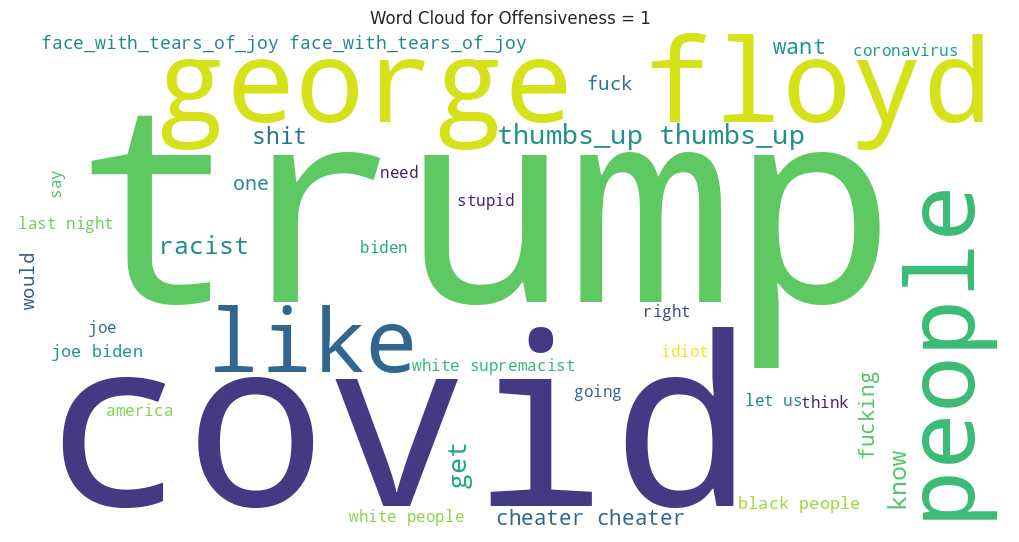

['trump', 'covid', 'george floyd', 'people', 'like', 'thumbs_up thumbs_up', 'get', 'racist', 'know', 'shit', 'want', 'fucking', 'cheater cheater', 'one', 'fuck', 'would', 'face_with_tears_of_joy face_with_tears_of_joy', 'joe biden', 'black people', 'white supremacist', 'let us', 'biden', 'america', 'idiot', 'think', 'say', 'joe', 'stupid', 'right', 'last night', 'coronavirus', 'going', 'need', 'white people', 'rolling_on_the_floor_laughing rolling_on_the_floor_laughing', 'white house', 'lives matter', 'donald trump', 'make', 'lie', 'go', 'blacklivesmatter', 'u', 'wear mask', 'covid death', 'black lives', 'piece shit', 'enraged_face enraged_face', 'vote', 'president trump', 'white supremacy', 'take', 'trump supporter', 'got', 'proud boys', 'looks like', 'guy', 'even', 'american people', 'wearing mask', 'shut fuck', 'thing', 'shut', 'well', 'get covid', 'united states', 'give shit', 'face_with_monocle face_with_monocle', 'ass', 'said', 'also', 'many people', 'loudly_crying_face loudly_cr

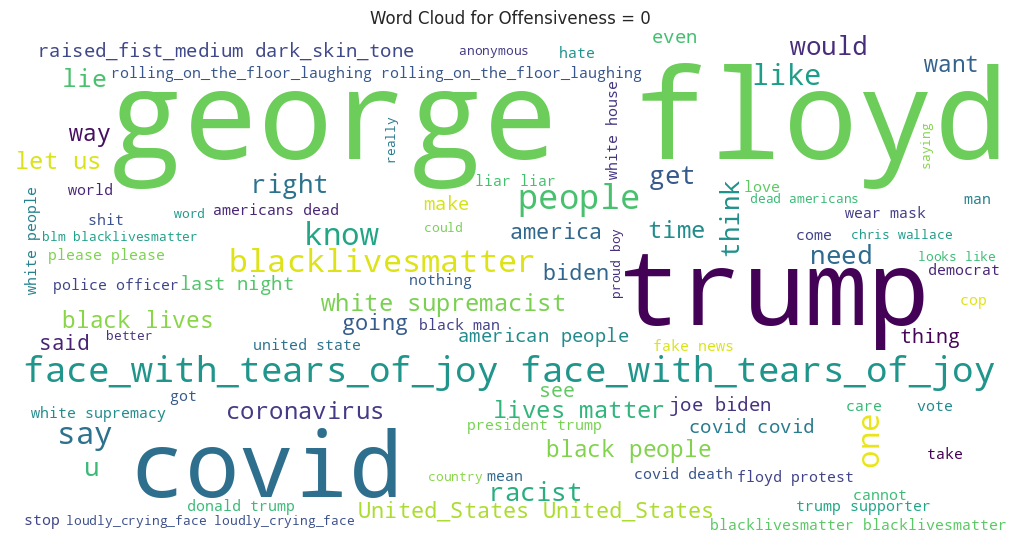

['george floyd', 'trump', 'covid', 'face_with_tears_of_joy face_with_tears_of_joy', 'people', 'blacklivesmatter', 'one', 'know', 'say', 'like', 'need', 'would', 'think', 'racist', 'u', 'get', 'right', 'lie', 'coronavirus', 'white supremacist', 'let us', 'time', 'lives matter', 'black people', 'black lives', 'want', 'way', 'going', 'biden', 'america', 'United_States United_States', 'said', 'see', 'thing', 'joe biden', 'make', 'raised_fist_medium dark_skin_tone', 'even', 'covid covid', 'last night', 'american people', 'rolling_on_the_floor_laughing rolling_on_the_floor_laughing', 'please please', 'got', 'cannot', 'wear mask', 'hate', 'white people', 'come', 'trump supporter', 'white supremacy', 'donald trump', 'covid death', 'democrat', 'man', 'united state', 'take', 'black man', 'liar liar', 'vote', 'stop', 'mean', 'americans dead', 'cop', 'love', 'white house', 'nothing', 'care', 'president trump', 'fake news', 'world', 'blacklivesmatter blacklivesmatter', 'floyd protest', 'police offi

In [ ]:
words_md_1 = generate_wordcloud(md_agreement_exploded, 1, "md_offensive_wordcloud.png")
print(words_md_1)

words_md_0 = generate_wordcloud(md_agreement_exploded, 0, "md_not_offensive_wordcloud.png")
print(words_md_0)

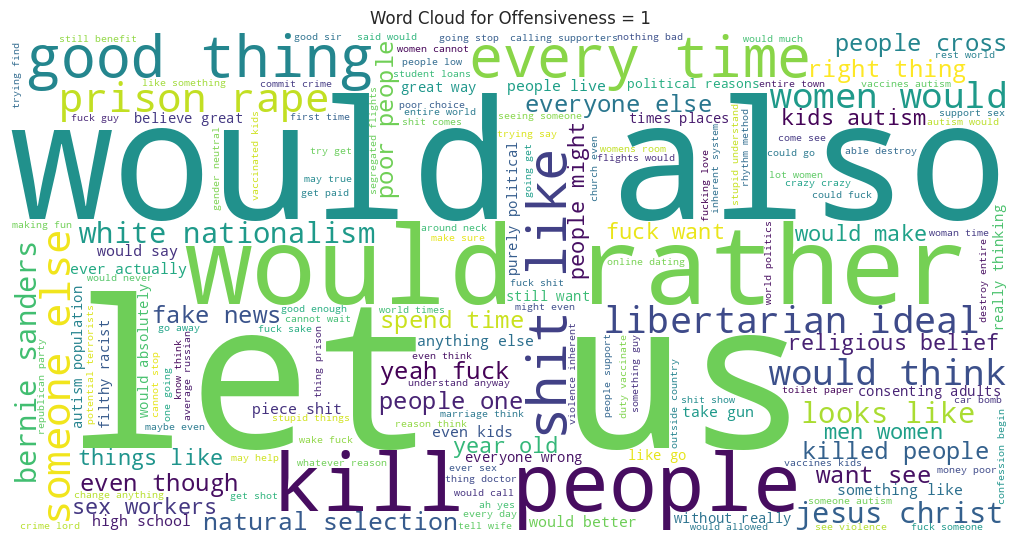

['let us', 'would also', 'would rather', 'kill people', 'good thing', 'every time', 'shit like', 'prison rape', 'someone else', 'libertarian ideal', 'would think', 'women would', 'white nationalism', 'jesus christ', 'looks like', 'bernie sanders', 'natural selection', 'killed people', 'want see', 'everyone else', 'even though', 'right thing', 'fake news', 'people cross', 'yeah fuck', 'spend time', 'poor people', 'people one', 'religious belief', 'year old', 'things like', 'kids autism', 'fuck want', 'men women', 'would make', 'people might', 'sex workers', 'something like', 'would say', 'even kids', 'would better', 'anything else', 'piece shit', 'ever actually', 'people live', 'take gun', 'high school', 'like go', 'consenting adults', 'still want', 'believe great', 'great way', 'times places', 'purely political', 'would absolutely', 'autism population', 'everyone wrong', 'filthy racist', 'without really', 'really thinking', 'political reasons', 'calling supporters', 'vaccinated kids', 

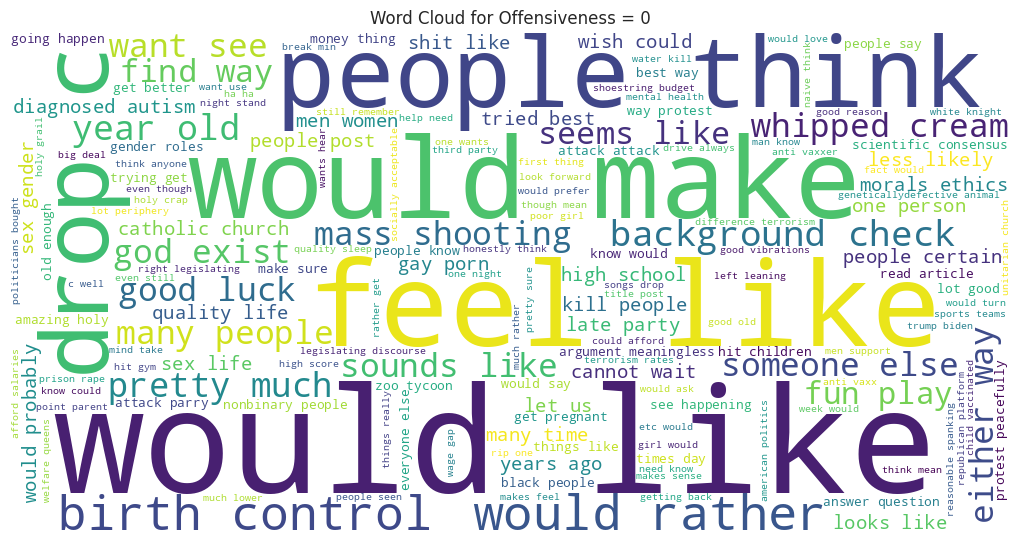

['george floyd', 'trump', 'covid', 'face_with_tears_of_joy face_with_tears_of_joy', 'people', 'blacklivesmatter', 'one', 'know', 'say', 'like', 'need', 'would', 'think', 'racist', 'u', 'get', 'right', 'lie', 'coronavirus', 'white supremacist', 'let us', 'time', 'lives matter', 'black people', 'black lives', 'want', 'way', 'going', 'biden', 'america', 'United_States United_States', 'said', 'see', 'thing', 'joe biden', 'make', 'raised_fist_medium dark_skin_tone', 'even', 'covid covid', 'last night', 'american people', 'rolling_on_the_floor_laughing rolling_on_the_floor_laughing', 'please please', 'got', 'cannot', 'wear mask', 'hate', 'white people', 'come', 'trump supporter', 'white supremacy', 'donald trump', 'covid death', 'democrat', 'man', 'united state', 'take', 'black man', 'liar liar', 'vote', 'stop', 'mean', 'americans dead', 'cop', 'love', 'white house', 'nothing', 'care', 'president trump', 'fake news', 'world', 'blacklivesmatter blacklivesmatter', 'floyd protest', 'police offi

In [ ]:
words_op_1 = generate_wordcloud(merged_df, 1, "op_offensive_wordcloud.png")
print(words_op_1)

words_op_0 = generate_wordcloud(merged_df, 0, "op_not_offensive_wordcloud.png")
print(words_md_0)

**Frequency analysis on the most common words**

In [ ]:
def generate_frequency_analysis(data, label_score, max_words=100):
    # Filter data for the specified hard_label score
    filtered_texts = data[data['hard_label'] == label_score]['cleaned_text'].str.cat(sep=' ')

    # Frequency Analysis
    words = filtered_texts.split()
    word_counts = Counter(words)
    most_common_words = word_counts.most_common(max_words)

    # Plot most common words and their counts
    common_words, counts = zip(*most_common_words)

    # Layout for the bar chart
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.barh(common_words, counts)
    ax.invert_yaxis()  # Highest counts at the top
    ax.set_title(f"Top {max_words} Most Common Words for Offensiveness = {label_score}")

    plt.tight_layout(pad = 0)
    plt.show()

    return most_common_words

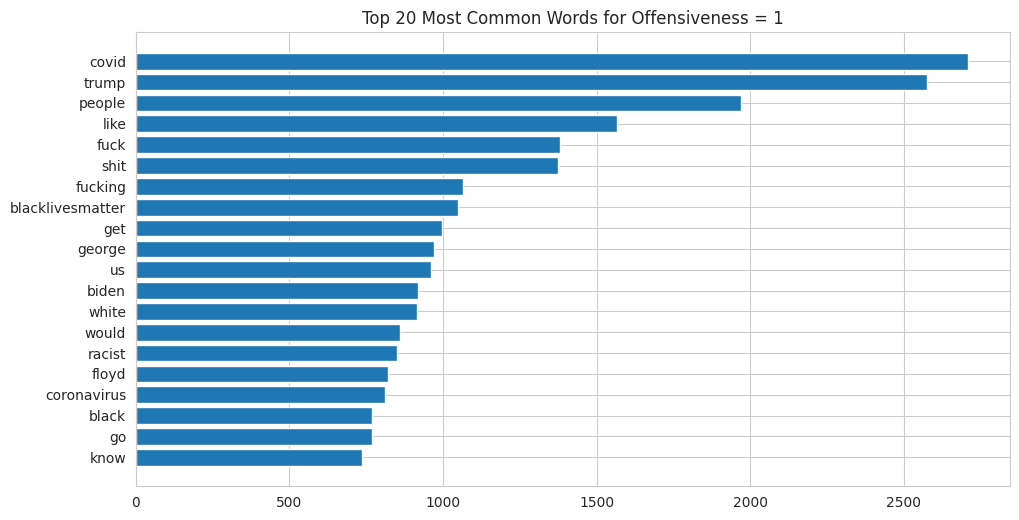

[('covid', 2710), ('trump', 2575), ('people', 1970), ('like', 1565), ('fuck', 1380), ('shit', 1375), ('fucking', 1065), ('blacklivesmatter', 1050), ('get', 995), ('george', 970), ('us', 960), ('biden', 920), ('white', 915), ('would', 860), ('racist', 850), ('floyd', 820), ('coronavirus', 810), ('black', 770), ('go', 770), ('know', 735)]


In [ ]:
bar_op_1 = generate_frequency_analysis(md_agreement_exploded, 1, 20)
print(bar_op_1)

## TF-IDF Weighted Wordclouds

A TF-IDF weighted word cloud highlights words that are frequent in the specific hate speech text relative to the entire collection of text in the dataset, pinpointing unique terminology. A regular word cloud might overemphasise commonly used words across all comments in contrast. Therefore, this method helps to get the most important words out from the corpus. The max_df and min_df also means that most common filler/stopwords and very rare words can also be filtered out.

In [ ]:
###  Return the top N TF-IDF features for texts corresponding to a specified label

def top_tfidf_features(data, label_score, top_n=50, min_df=5, max_df=0.85, sublinear_tf=True):
    # Filter data for the specified hard_label score
    filtered_texts = data[data['hard_label'] == label_score]['cleaned_text']

    # Initialise TF-IDF Vectoriser with additional parameters
    vectorizer = TfidfVectorizer(stop_words='english',
                                 ngram_range=(1,2),
                                 min_df=min_df,
                                 max_df=max_df,
                                 sublinear_tf=sublinear_tf)
    tfidf_matrix = vectorizer.fit_transform(filtered_texts)

    # Get feature names (words)
    feature_names = vectorizer.get_feature_names_out()

    # Get mean tf-idf scores for each word
    mean_tfidf_scores = tfidf_matrix.mean(axis=0).tolist()[0]

    # Sort words by mean tf-idf score
    sorted_scores = sorted([(score, word) for word, score in zip(feature_names, mean_tfidf_scores)], reverse=True)

    # Get top_n words with highest tf-idf scores
    top_features = sorted_scores[:top_n]

    return top_features

In [ ]:
top_features_offensive_md = top_tfidf_features(md_agreement_exploded, label_score=1, top_n=50)
top_features_offensive_md

[(0.012266169707656495, 'trump'),
 (0.012080933089330038, 'covid'),
 (0.01186674440801908, 'fuck'),
 (0.009693265268782083, 'people'),
 (0.009676373595002194, 'shit'),
 (0.008278563559567081, 'like'),
 (0.007491708213283201, 'fucking'),
 (0.006697925247829169, 'blacklivesmatter'),
 (0.006103652893795569, 'biden'),
 (0.005887407637620082, 'george'),
 (0.005842512659615965, 'racist'),
 (0.005633328678306643, 'white'),
 (0.005501921887161303, 'floyd'),
 (0.0054653620206004, 'stupid'),
 (0.005359963800356386, 'ass'),
 (0.005342516153646706, 'george floyd'),
 (0.005212723854699505, 'joe'),
 (0.005157724644563017, 'bullshit'),
 (0.004973074256225762, 'coronavirus'),
 (0.0048062366275923, 'going'),
 (0.004799914631926049, 'know'),
 (0.00468137041197694, 'black'),
 (0.004434360485155702, 'man'),
 (0.004429935881059166, 'shut'),
 (0.004393716879853397, 'president'),
 (0.004084836496494641, 'want'),
 (0.003807294394492274, 'got'),
 (0.0037755932365007264, 'vote'),
 (0.0037168383581469137, 'right

In [ ]:
top_features_notoffensive_md = top_tfidf_features(md_agreement_exploded, label_score=0, top_n=50)
top_features_notoffensive_md

[(0.014170723862718004, 'blacklivesmatter'),
 (0.011941337814618017, 'trump'),
 (0.011527462223568957, 'covid'),
 (0.010100834546548443, 'people'),
 (0.008111500409011934, 'george'),
 (0.0076929835504142485, 'floyd'),
 (0.007396004476068779, 'george floyd'),
 (0.0064841386633941464, 'like'),
 (0.006050356449500136, 'black'),
 (0.006027244402689739, 'coronavirus'),
 (0.005068478143225207, 'going'),
 (0.004912904526671616, 'face_with_tears_of_joy'),
 (0.0047186570085144324, 'white'),
 (0.004692393862898525, 'know'),
 (0.004279743051905824, 'stop'),
 (0.0041276265825983295, 'man'),
 (0.004064392182395884, 'right'),
 (0.004016731031451089, 'say'),
 (0.003932211923196827, 'biden'),
 (0.00368839268197751, 'police'),
 (0.003687049248994914, 'america'),
 (0.0036310792798864653, 'vote'),
 (0.003630098723318962, 'racist'),
 (0.0035810414372745365, 'way'),
 (0.0035544798104681437, 'president'),
 (0.0034190929298854146, 'hell'),
 (0.0033493993175686956, 'think'),
 (0.0032482712849272143, 'joe'),
 

In [ ]:
### Generating a wordcloud based on top TF-IDF features

def generate_tfidf_wordcloud(top_features, save_path, label=""):
    # Convert TF-IDF top features into dictionary format suitable for WordCloud
    tfidf_dict = {word: score for score, word in top_features}

    # Generate a word cloud using TF-IDF scores as weights
    wordcloud = WordCloud(width = 1000, height = 500,
                          background_color ='white',
                          max_words=len(tfidf_dict),
                          min_font_size = 10).generate_from_frequencies(tfidf_dict)

    # Plot the word cloud image
    plt.figure(figsize = (10, 5), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(f"TF-IDF weighted word cloud for words rated as {label}")

    # Save the image to the provided path
    plt.savefig(save_path, format='png')

    plt.show()

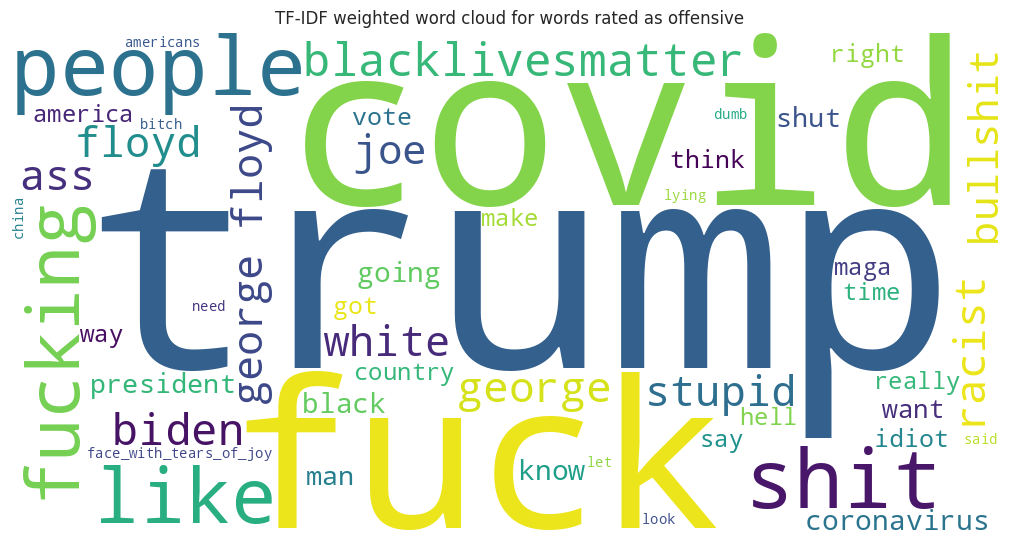

In [ ]:
generate_tfidf_wordcloud(top_features_offensive_md, "md_offensive_tfidfwordcloud.png", "offensive")

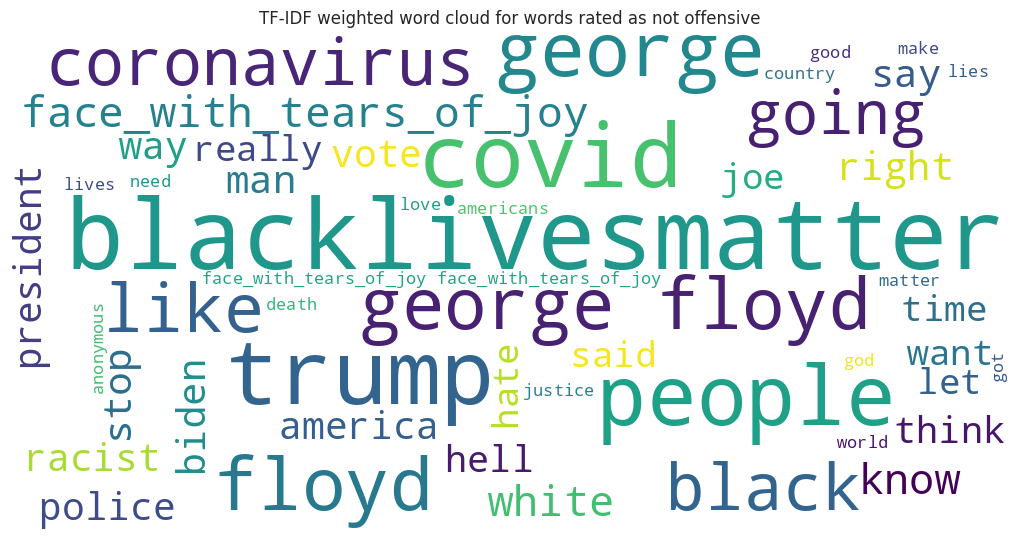

In [ ]:
generate_tfidf_wordcloud(top_features_notoffensive_md, "md_not_offensive_tfidfwordcloud.png", "not offensive")

In [ ]:
### Generating a bar chart showing the top top TF-IDF features

def generate_tfidf_barchart(top_features, label="", max_words=20):
    # If max_words is specified, limit the features
    if max_words:
        top_features = top_features[:max_words]

    # Extract words and their respective scores
    words = [word for score, word in top_features]
    scores = [score for score, word in top_features]

    # Plotting the bar chart
    plt.figure(figsize=(12, 8))
    plt.barh(words[::-1], scores[::-1], color='blue')
    plt.xlabel('TF-IDF Score')
    plt.ylabel('Words')
    plt.title(f"TF-IDF scores for words rated as {label}")
    plt.show()

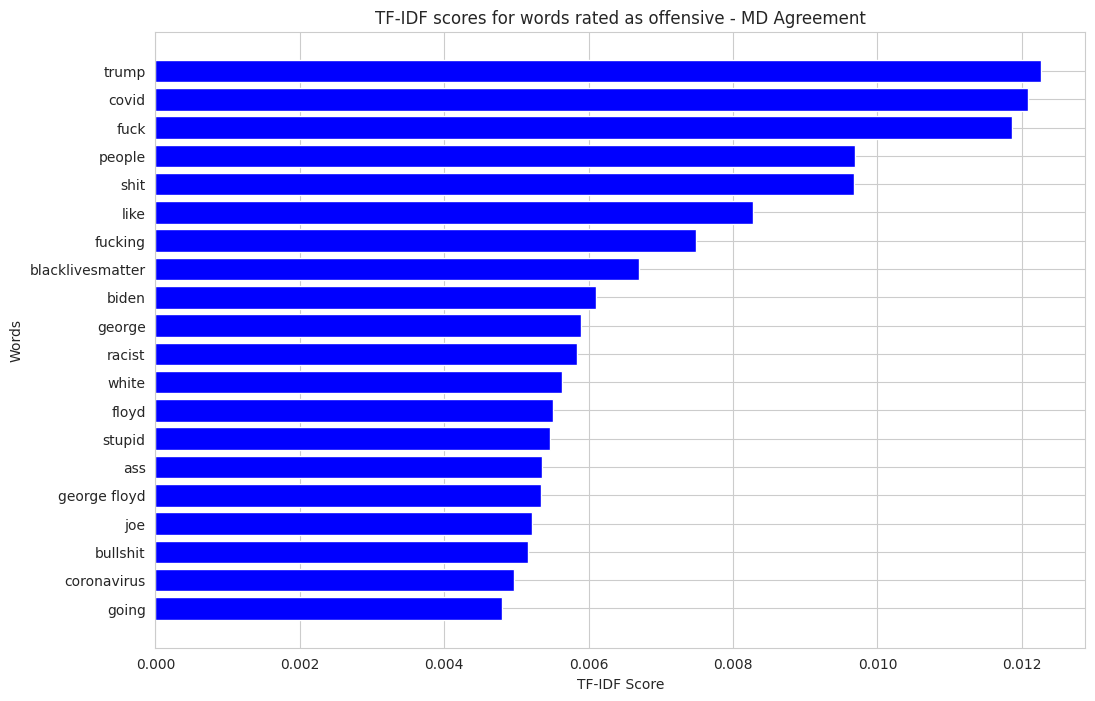

In [ ]:
generate_tfidf_barchart(top_features_offensive_md, label="offensive - MD Agreement", max_words=20)

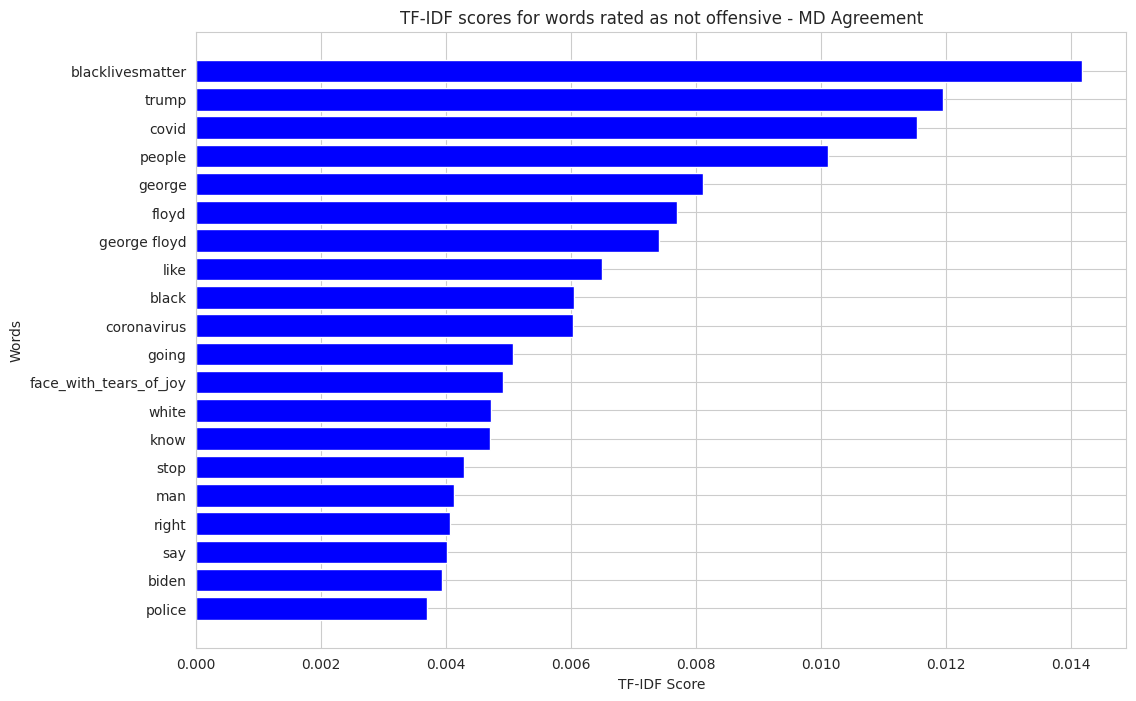

In [ ]:
generate_tfidf_barchart(top_features_notoffensive_md, label="not offensive - MD Agreement", max_words=20)

**Do the same with the OP dataset**

In [ ]:
top_features_offensive_op = top_tfidf_features(merged_df, label_score=1, top_n=50)
top_features_offensive_op

[(0.01639588094864894, 'fuck'),
 (0.013197607490366277, 'people'),
 (0.012458925127331384, 'like'),
 (0.008458666276714119, 'want'),
 (0.008438953030410933, 'kill'),
 (0.00832138160784347, 'shit'),
 (0.00791569711025858, 'sex'),
 (0.0075562842038203555, 'fucking'),
 (0.007451490859478827, 'know'),
 (0.007118116918625087, 'think'),
 (0.0067839328940433406, 'going'),
 (0.00647102669009675, 'autism'),
 (0.006437124901783761, 'kids'),
 (0.006250974600376448, 'time'),
 (0.006042330530820092, 'got'),
 (0.00573161210468399, 'right'),
 (0.0055956978228219306, 'hell'),
 (0.00539735505762724, 'women'),
 (0.00535276576804621, 'good'),
 (0.005335232530529403, 'make'),
 (0.005189472566665884, 'way'),
 (0.005054308642026345, 'thing'),
 (0.005041181465454026, 'really'),
 (0.0049009572661725355, 'guy'),
 (0.004892679592504503, 'world'),
 (0.004614592635845881, 'yeah'),
 (0.0045698101305962436, 'money'),
 (0.004484418333988754, 'need'),
 (0.004478324439787017, 'work'),
 (0.004472056044609219, 'let'),
 

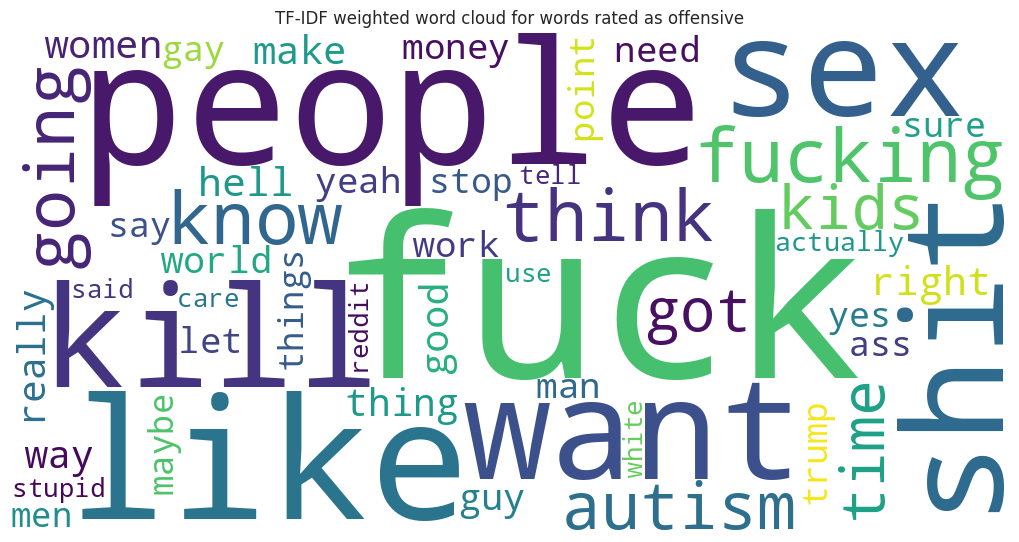

In [ ]:
generate_tfidf_wordcloud(top_features_offensive_op, "op_offensive_tfidfwordcloud.png", "offensive")

In [ ]:
top_features_nonoffensive_op = top_tfidf_features(merged_df, label_score=0, top_n=50)
top_features_nonoffensive_op

[(0.011104827343943937, 'like'),
 (0.01092595801401132, 'people'),
 (0.008805845833287806, 'good'),
 (0.007792982338106569, 'think'),
 (0.0068482607914640515, 'know'),
 (0.00641079954810555, 'right'),
 (0.006185323091282626, 'make'),
 (0.006128118914198434, 'time'),
 (0.005924188386332065, 'way'),
 (0.005852891551997232, 'really'),
 (0.005649177820711547, 'want'),
 (0.00538049851950997, 'going'),
 (0.004860361495830793, 'hope'),
 (0.004773177774363007, 'need'),
 (0.0047219935988701955, 'things'),
 (0.004694873623358786, 'sex'),
 (0.004542035631136496, 'late'),
 (0.004449741677364935, 'better'),
 (0.004322715482020564, 'money'),
 (0.004178614448398165, 'actually'),
 (0.00417772979820216, 'mean'),
 (0.003909260787227807, 'love'),
 (0.0038910617679652746, 'try'),
 (0.003859976226494481, 'got'),
 (0.0037352826900706178, 'believe'),
 (0.003703029113659551, 'point'),
 (0.003620061577696404, 'say'),
 (0.0035247116636539354, 'wait'),
 (0.0034634409555420855, 'life'),
 (0.003406014670854079, 't

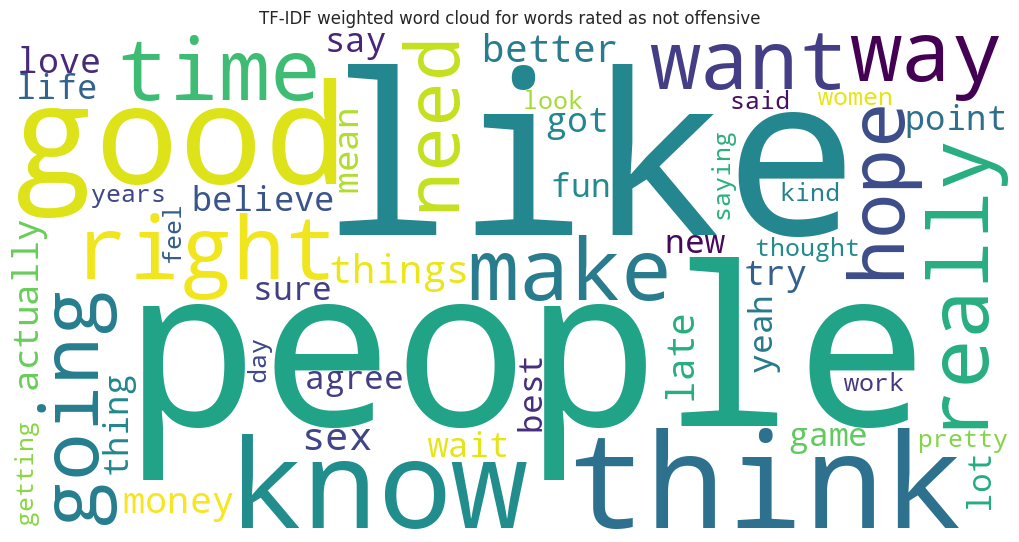

In [ ]:
generate_tfidf_wordcloud(top_features_nonoffensive_op, "op_not_offensive_tfidfwordcloud.png", "not offensive")

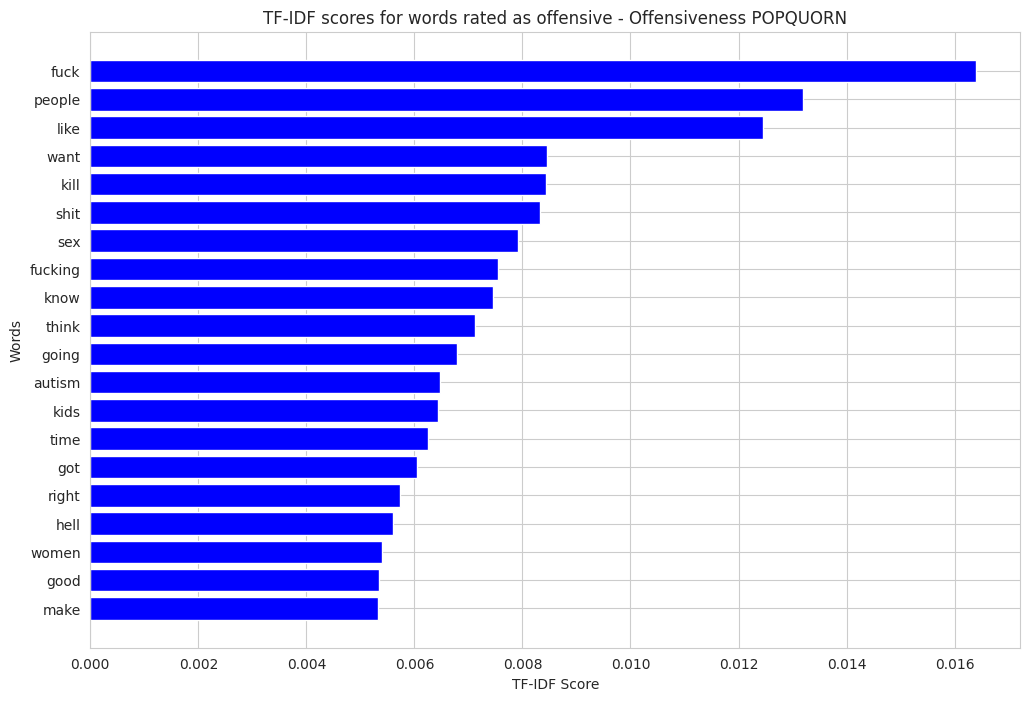

In [ ]:
generate_tfidf_barchart(top_features_offensive_op, label="offensive - Offensiveness POPQUORN", max_words=20)

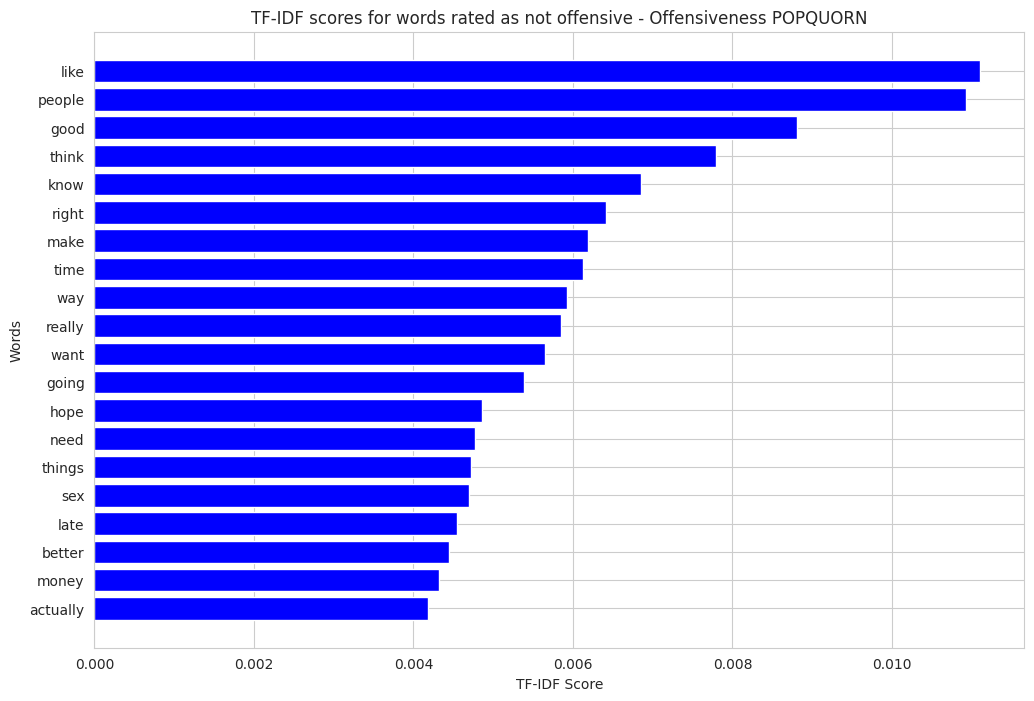

In [ ]:
generate_tfidf_barchart(top_features_nonoffensive_op, label="not offensive - Offensiveness POPQUORN", max_words=20)

We can see that a lot of the words overlap between the offensive and non-offensive features output. Here we are finding top unique words present in both.

In [ ]:
### Determine and return the unique top TF-IDF features between two label scores.

def unique_common_features(data, label_score_1, label_score_2, top_n=50, ngram_range=(1, 1)):
    # Initialise TF-IDF Vectoriser with the specified ngram setting
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, stop_words='english', max_features=10000)

    # Get texts for each label
    texts_1 = data[data['hard_label'] == label_score_1]['cleaned_text']
    texts_2 = data[data['hard_label'] == label_score_2]['cleaned_text']

    # Fit the vectorizer and transform texts for each label
    tfidf_matrix_1 = vectorizer.fit_transform(texts_1)
    tfidf_matrix_2 = vectorizer.transform(texts_2)

    # Get feature names
    feature_names = vectorizer.get_feature_names_out()

    # Calculate mean tf-idf scores for each feature in each label
    mean_tfidf_1 = tfidf_matrix_1.mean(axis=0).tolist()[0]
    mean_tfidf_2 = tfidf_matrix_2.mean(axis=0).tolist()[0]

    # Sort features by mean tf-idf score for each label
    sorted_scores_1 = sorted([(score, feature) for feature, score in zip(feature_names, mean_tfidf_1)], reverse=True)[:top_n]
    sorted_scores_2 = sorted([(score, feature) for feature, score in zip(feature_names, mean_tfidf_2)], reverse=True)[:top_n]

    # Extract top features for each label
    top_features_1 = set([feature for score, feature in sorted_scores_1])
    top_features_2 = set([feature for score, feature in sorted_scores_2])

    # Identify unique features for each label
    unique_features_1 = top_features_1 - top_features_2
    unique_features_2 = top_features_2 - top_features_1

    return unique_features_1, unique_features_2

MD-Agreement

In [ ]:
unique_words_offensive, unique_words_non_offensive = unique_common_features(md_agreement_exploded, label_score_1=1, label_score_2=0, top_n=50)

In [ ]:
unique_words_offensive

{'ass',
 'bitch',
 'bullshit',
 'china',
 'dumb',
 'family',
 'fuck',
 'fucking',
 'got',
 'idiot',
 'look',
 'lying',
 'maga',
 'make',
 'shit',
 'shut',
 'stupid'}

In [ ]:
unique_words_non_offensive

{'american',
 'anonymous',
 'death',
 'georgefloyd',
 'god',
 'good',
 'hate',
 'justice',
 'killed',
 'lies',
 'lives',
 'love',
 'matter',
 'minneapolis',
 'police',
 'stop',
 'world'}

Offensiveness POPQUORN

In [ ]:
unique_words_offensive, unique_words_non_offensive = unique_common_features(merged_df, label_score_1=1, label_score_2=0, top_n=50)

In [ ]:
unique_words_offensive

{'ass',
 'autism',
 'care',
 'fuck',
 'fucking',
 'gay',
 'guy',
 'hell',
 'kids',
 'kill',
 'let',
 'man',
 'maybe',
 'men',
 'reddit',
 'shit',
 'stop',
 'stupid',
 'tell',
 'trump',
 'use',
 'white',
 'women',
 'world',
 'yeah',
 'yes'}

In [ ]:
unique_words_non_offensive

{'agree',
 'awesome',
 'believe',
 'best',
 'better',
 'feel',
 'fun',
 'game',
 'high',
 'hope',
 'kind',
 'late',
 'life',
 'look',
 'lot',
 'love',
 'mean',
 'new',
 'pretty',
 'real',
 'saying',
 'thought',
 'try',
 'wait',
 'waiting',
 'years'}

# Clean text to use for next steps (more limited cleaning to keep context for BERT based models)

In the function, numbers, punctuation, and stopwords are retained to enhance BERT classification models, allowing the entire text to undergo BERT's native preprocessing. Another vital preprocessing step included in the function is the expansion of contractions (processed in the main function), which is essential for BERT-based models.

In [ ]:
md_agreement_exploded['cleaned_text'] = md_agreement_exploded['text'].apply(clean_text, remove_numbers=False, remove_punctuation=False, remove_stopwords=False)
md_agreement_exploded['cleaned_domain'] = md_agreement_exploded['other_info.domain'].apply(clean_text, remove_numbers=False, remove_punctuation=False, remove_stopwords=False)
merged_df['cleaned_text'] = merged_df['text'].apply(clean_text, remove_numbers=False, remove_punctuation=False, remove_stopwords=False)

In [ ]:
md_agreement_exploded[['text','cleaned_text']].head(25)

,text,cleaned_text
0,"<user> <user> 30 million unemployed , fool","30 million unemployed , fool"
1,"<user> <user> 30 million unemployed , fool","30 million unemployed , fool"
2,"<user> <user> 30 million unemployed , fool","30 million unemployed , fool"
3,"<user> <user> 30 million unemployed , fool","30 million unemployed , fool"
4,"<user> <user> 30 million unemployed , fool","30 million unemployed , fool"
5,. <user> <user> <user> <user> <user> <user> #W...,. #wedontbuyhate this is powerful. watch
6,. <user> <user> <user> <user> <user> <user> #W...,. #wedontbuyhate this is powerful. watch
7,. <user> <user> <user> <user> <user> <user> #W...,. #wedontbuyhate this is powerful. watch
8,. <user> <user> <user> <user> <user> <user> #W...,. #wedontbuyhate this is powerful. watch
9,. <user> <user> <user> <user> <user> <user> #W...,. #wedontbuyhate this is powerful. watch


In [ ]:
merged_df[['text','cleaned_text']].head(25)

,text,cleaned_text
0,"I think a lot of Dethklok songs use drop C, wo...","i think a lot of dethklok songs use drop c, wo..."
1,"I think a lot of Dethklok songs use drop C, wo...","i think a lot of dethklok songs use drop c, wo..."
2,"I think a lot of Dethklok songs use drop C, wo...","i think a lot of dethklok songs use drop c, wo..."
3,"I think a lot of Dethklok songs use drop C, wo...","i think a lot of dethklok songs use drop c, wo..."
4,"I think a lot of Dethklok songs use drop C, wo...","i think a lot of dethklok songs use drop c, wo..."
5,"I think a lot of Dethklok songs use drop C, wo...","i think a lot of dethklok songs use drop c, wo..."
6,"I think a lot of Dethklok songs use drop C, wo...","i think a lot of dethklok songs use drop c, wo..."
7,"I think a lot of Dethklok songs use drop C, wo...","i think a lot of dethklok songs use drop c, wo..."
8,There are relatively simple ways around all of...,there are relatively simple ways around all of...
9,There are relatively simple ways around all of...,there are relatively simple ways around all of...


# Save cleaned files for full datasets

In [ ]:
merged_df.to_csv("offensiveness_popquorn_cleaned.csv", index=False)

In [ ]:
md_agreement_exploded.to_csv("md_agreement_cleaned.csv", index=False)